<a href="https://colab.research.google.com/github/cewgs/Unsupervised-Learning-Project/blob/main/unsupervised_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run the following cell to clone the project repository and install required dependencies.
After running this cell, all data files and notebooks will be available in the Colab environment

In [1]:
# clone repo if not already cloned and install dependency
import os

if not os.path.exists("Unsupervised-Learning-Project"):
    !git clone https://github.com/cewgs/Unsupervised-Learning-Project.git

%cd Unsupervised-Learning-Project

# Install required external library
!pip install -q gower


Cloning into 'Unsupervised-Learning-Project'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 41 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 1.67 MiB | 7.11 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/Unsupervised-Learning-Project


In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
import gower
from scipy.stats import chi2_contingency
import random


#### Survey Data from 2017-2021

In [3]:
data_frames = []

data_paths = [

   'Survey Data/2017.csv',
   'Survey Data/2018.csv',
   'Survey Data/2019.csv',
   'Survey Data/2020.csv',
   'Survey Data/2021.csv',
]

col_renames = {
    '*Are you self-employed?*': 'self_employed',
    '<strong>Are you self-employed?</strong>': 'self_employed',
    'Is your employer primarily a tech company/organization?': 'tech_company',
    'Is your primary role within your company related to tech/IT?': 'tech_related_role',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'benefits',
    'Does your employer provide mental health benefits as part of healthcare coverage?': 'benefits',
    'Does your employer offer resources to learn more about mental health disorders and options for seeking help?': 'workplace_resources',
    'Have you ever discussed your mental health with your employer?': 'mh_employer_discussion',
    'Have you ever discussed your mental health with coworkers?': 'mh_coworker_discussion',
    'Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?': 'medical_coverage',
    'Do you currently have a mental health disorder?': 'mental_health',
    'Do you *currently* have a mental health disorder?': 'mental_health',
    'Do you *currently* have a mental health disorder?': 'mental_health',
    'How willing would you be to share with friends and family that you have a mental illness?': 'mh_share',
    'What is your age?': 'age',
    'What is your gender?': 'gender',
    'What country do you *live* in?': 'country',
    'What country do you <strong>live</strong> in?': 'country',
    'Does your employer provide mental health benefits as part of healthcare coverage?	': 'benefits',
}

col_to_keep = col_renames.keys()

In [4]:
# Importing the files
for path in data_paths:
  print("\nReading file: ", path)
  df = pd.read_csv(path)
  print('Shape - default: ', df.shape)

  # Dropping columns > 90% missing values
  max_na_filter = (0.9 * len(df))
  df = df.loc[:,(df.isnull().sum(axis = 0) <= max_na_filter)]
  print('Shape filtered: ', df.shape)

  col_to_drop = [item for item in df.columns if item not in col_to_keep]
  df.drop(columns = col_to_drop, inplace = True, errors = 'ignore')
  print('Shape of column filtered: ', df.shape)

  # Renaming columns across the datasets
  df.drop(columns = col_to_drop, inplace = True, errors = 'ignore')
  df.rename(columns = col_renames, inplace = True, errors = 'ignore')

  data_frames.append(df)


Reading file:  Survey Data/2017.csv
Shape - default:  (756, 123)
Shape filtered:  (756, 84)
Shape of column filtered:  (756, 13)

Reading file:  Survey Data/2018.csv
Shape - default:  (417, 123)
Shape filtered:  (417, 84)
Shape of column filtered:  (417, 13)

Reading file:  Survey Data/2019.csv
Shape - default:  (352, 82)
Shape filtered:  (352, 78)
Shape of column filtered:  (352, 13)

Reading file:  Survey Data/2020.csv
Shape - default:  (180, 120)
Shape filtered:  (180, 81)
Shape of column filtered:  (180, 13)

Reading file:  Survey Data/2021.csv
Shape - default:  (131, 124)
Shape filtered:  (131, 83)
Shape of column filtered:  (131, 13)


In [5]:
df = pd.concat(data_frames, ignore_index = True)
print('combined data shape: ', df.shape)

combined data shape:  (1836, 13)


In [6]:
# Overview
df.head()

,self_employed,tech_company,tech_related_role,benefits,workplace_resources,mh_employer_discussion,mh_coworker_discussion,medical_coverage,mental_health,mh_share,age,gender,country
0,0,1.0,1.0,No,I don't know,0.0,1.0,NaN,Possibly,5,27.0,Female,United Kingdom
1,0,1.0,1.0,Yes,No,0.0,1.0,NaN,Possibly,4,31.0,male,United Kingdom
2,0,1.0,1.0,I don't know,No,1.0,1.0,NaN,Yes,5,36.0,male,United States of America
3,0,1.0,1.0,Yes,I don't know,1.0,1.0,NaN,Yes,10,22.0,Male,United States of America
4,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No,10,52.0,female,United States of America


In [7]:
# dtypes
df.dtypes

,0
self_employed,int64
tech_company,object
tech_related_role,object
benefits,object
workplace_resources,object
mh_employer_discussion,object
mh_coworker_discussion,object
medical_coverage,object
mental_health,object
mh_share,int64


### Data Cleaning

In [8]:
# number of missing values
display(df.isna().sum().sort_values())
display(print("df shape:", df.shape))

,0
self_employed,0
mental_health,0
mh_share,0
age,2
country,2
gender,28
tech_related_role,259
tech_company,259
benefits,259
workplace_resources,259


df shape: (1836, 13)


None

##### Tech related roles
reduce the dataset to tech related roles
In this merged dataset we dont have the exact roles for each employee. So we drop rows with missing values. Some other surveys did include the exact roles which would allow to impute the column "tech_related_role". Further, this dataset only contains employed, not self-employed.

In [9]:
# drop missing values in tech_related_role
df = df[df['tech_related_role'].notna()]

In [10]:
df['tech_related_role'].value_counts()

,count
tech_related_role,
1.0,1463
0.0,114


In [11]:
#remove non tech related roles
df.drop(df[df['tech_related_role'] == 0.0].index, inplace = True) # only tech roles remain

# drop the column 'tech_related_roles'
df.drop(columns = 'tech_related_role', inplace = True)


#### Mental Health

In [12]:
display(df.isna().sum().sort_values())

,0
self_employed,0
tech_company,0
benefits,0
workplace_resources,0
mh_employer_discussion,0
mental_health,0
age,0
mh_share,0
country,0
mh_coworker_discussion,3


In [13]:
df["mental_health"].value_counts()

,count
mental_health,
Yes,596
No,434
Possibly,307
Don't Know,126


#### Gender

In [14]:
df['gender'].value_counts()

,count
gender,
Male,616
male,217
Female,215
female,112
M,55
...,...
MALE,1
b,1
male/he/him,1


In [15]:
# marking 25 missing values as "others"
df['gender'] = df['gender'].fillna('Other')

# format the records e.g. male/ Male
df['gender'] = df['gender'].str.lower().str.strip()

In [16]:
# group different genders into male, female, other

gender_male = ['male', 'm', 'man', 'male/he/him', 'let\'s keep it simple and say \"male\"', 'mostly male', 'masculine', 'identify as male', 'masculino', 'cishet male', 'cis male', 'mail', 'male-ish', 'cis-male', 'male (cis)', 'cis hetero male', 'dude', 'cisgender male', 'male, born with xy chromosoms', 'swm', 'ostensibly male']
gender_female = ['female', 'f', 'woman', 'female, she/her', 'femile', 'female (cis)', 'f, cisgender', 'cisgendered woman', 'femmina', 'cis female', 'cis woman', 'cis-female', 'genderqueer demigirl', 'female (cisgender)', 'my sex is female.', 'femail', 'femalw', 'nonbinary/femme', 'cisgender female', 'she/her/they/them', '*shrug emoji* (f)',  'female/gender non-binary.', 'i identify as female']
gender_other = ['agender', 'nonbinary', 'nb', 'b', '43','non-binary and gender fluid', 'gender non-conforming woman','cis-het male', 'demiguy', 'trans non-binary/genderfluid', 'other', 'afab non-binary', 'sometimes', 'questioning', 'none', 'trans man', 'trans woman', 'trans female', 'non-binary/agender', 'make', 'agender trans woman', 'transfeminine', '\-', 'genderqueer/non-binary', 'non binary', 'contextual', 'agender/genderfluid', 'non-binary', 'genderfluid', 'god king of the valajar', 'uhhhhhhhhh fem genderqueer?', 'transgender', 'genderqueer', 'homem cis']

# transform gender in simpler form
df['gender'] = df['gender'].replace(gender_male, 'Male')
df['gender'] = df['gender'].replace(gender_female, 'Female')
df['gender'] = df['gender'].replace(gender_other, 'Other')

# lets check records now
df['gender'].value_counts()



<>:5: SyntaxWarning: invalid escape sequence '\-'
<>:5: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipython-input-1846883450.py:5: SyntaxWarning: invalid escape sequence '\-'
  gender_other = ['agender', 'nonbinary', 'nb', 'b', '43','non-binary and gender fluid', 'gender non-conforming woman','cis-het male', 'demiguy', 'trans non-binary/genderfluid', 'other', 'afab non-binary', 'sometimes', 'questioning', 'none', 'trans man', 'trans woman', 'trans female', 'non-binary/agender', 'make', 'agender trans woman', 'transfeminine', '\-', 'genderqueer/non-binary', 'non binary', 'contextual', 'agender/genderfluid', 'non-binary', 'genderfluid', 'god king of the valajar', 'uhhhhhhhhh fem genderqueer?', 'transgender', 'genderqueer', 'homem cis']


,count
gender,
Male,969
Female,432
Other,62


#### benefits

In [17]:
# check missing values
df.isna().sum().sort_values()

,0
self_employed,0
tech_company,0
benefits,0
workplace_resources,0
mh_employer_discussion,0
mental_health,0
age,0
mh_share,0
gender,0
country,0


In [18]:
df['benefits'].value_counts()

,count
benefits,
Yes,784
I don't know,389
No,222
Not eligible for coverage / NA,68


In [19]:
# 'Not eligible for coverage / NA', equal to'No'

df.loc[df['benefits'] == 'Not eligible for coverage / NA' , 'benefits'] = 'No'

df['benefits'].value_counts()

,count
benefits,
Yes,784
I don't know,389
No,290


#### workplace_resources

In [20]:
df['workplace_resources'].value_counts()

,count
workplace_resources,
No,626
Yes,455
I don't know,382


#### mh_employer_discussion

In [21]:
df['mh_employer_discussion'].value_counts()

,count
mh_employer_discussion,
0.0,1010
1.0,453


#### mh_coworker_discussion

In [22]:
df['mh_coworker_discussion'].value_counts()

,count
mh_coworker_discussion,
0.0,824
1.0,636


#### medical_coverage

In [23]:
# check missing values
df.isna().sum().sort_values()

,0
self_employed,0
tech_company,0
benefits,0
workplace_resources,0
mh_employer_discussion,0
mental_health,0
age,0
mh_share,0
gender,0
country,0


If the the employee has health benifits he should have medical coverage. Further we will use OECD (OECD-ilibrary.org) data to interpolate the coverage for certain countries.

In [24]:

# medical coverage if the company is providing health benefits
df.loc[df['benefits'] == 'Yes', 'medical_coverage'] = 'Yes'

# Employees are covered (Uk, Germany, Canada, France, Spain, Netherlands)
countries = ['UK', 'Germany', 'Canada', 'France', 'Spain', 'Netherlands']
df.loc[(df['country'].isin(countries)), 'medical_coverage'] = 'Yes'

# Lets check how many null values we have now
df['medical_coverage'].isna().sum()


np.int64(590)

In [25]:
# According to OECD, USA has 90% medical coverage
total_us = df.loc[df['country'] == 'United States of America']
no_coverage_us = df.loc[(df['medical_coverage'].isna()) & (df['country'] == 'United States of America')]

print('US employed :{}'.format(len(total_us)))
print('USA residents without medical coverage in df :{}'.format(len(no_coverage_us)))
print('not insured: ' + str(round(100*((len(no_coverage_us)) / (len(total_us))), 2)) + '%')


US employed :950
USA residents without medical coverage in df :315
not insured: 33.16%


In [26]:
# According to the OECD data 90 % in the US should be insured.
# we assign 95 more with insurance.

no_coverage_us_list = list(no_coverage_us.index)

sample = random.sample(no_coverage_us_list, 95) # assign randomly
(sample.sort())

df.loc[sample , 'medical_coverage'] = 'No'
df.loc[(df['country'] == 'United States of America') & (df['medical_coverage'].isna()) , 'medical_coverage'] = 'Yes'

df.isna().sum() / len(df)

,0
self_employed,0.000000
tech_company,0.000000
benefits,0.000000
workplace_resources,0.000000
mh_employer_discussion,0.000000
mh_coworker_discussion,0.002051
medical_coverage,0.187970
mental_health,0.000000
mh_share,0.000000
age,0.000000


In [27]:
# The remaining 14% will be dropped
df.dropna(inplace = True)

display(df.isna().sum())
display(print("df shape:", df.shape))


,0
self_employed,0
tech_company,0
benefits,0
workplace_resources,0
mh_employer_discussion,0
mh_coworker_discussion,0
medical_coverage,0
mental_health,0
mh_share,0
age,0


df shape: (1185, 12)


None

#### age

In [28]:
# We can see outliers as min age is 0.
df['age'].describe()

,age
count,1185.000000
mean,34.987342
std,8.207961
min,0.000000
25%,29.000000
50%,34.000000
75%,40.000000
max,66.000000


In [29]:
# number of unique values per unqiue
df['age'].value_counts()

,count
age,
30.0,71
37.0,69
32.0,60
28.0,59
35.0,56
31.0,54
27.0,53
34.0,52
29.0,51


In [30]:
# counts with age <= 18
df[(df["age"] <= 18)]

,self_employed,tech_company,benefits,workplace_resources,mh_employer_discussion,mh_coworker_discussion,medical_coverage,mental_health,mh_share,age,gender,country
1287,0,False,I don't know,I don't know,False,False,Yes,No,6,0.0,Male,United States of America


In [31]:
# Age 0 outlier, drop  outside 21-55 to avoid too small clusters (single counts)
# Drop rows where age <= 21 or age > 55
df = df.drop(df[(df["age"] < 20) | (df["age"] > 55)].index)

# Check summary statistics after dropping
df['age'].describe()


,age
count,1160.000000
mean,34.675000
std,7.489681
min,20.000000
25%,29.000000
50%,34.000000
75%,40.000000
max,55.000000


#### mh_share

In [32]:
# ranges from 0 - 10, ordinal
df['mh_share']

,mh_share
1,4
2,5
3,10
6,8
7,3
...,...
1821,0
1822,10
1827,9
1829,10


#### formatting

In [33]:
df['self_employed'] = df['self_employed'].replace({1 : 'Yes' , 0 : 'No'})
df['tech_company'] = df['tech_company'].replace({1.0 : 'Yes' , 0.0 : 'No'})
df['mh_employer_discussion'] = df['mh_employer_discussion'].replace({1.0 : 'Yes' , 0.0 : 'No'})
df['mh_coworker_discussion'] = df['mh_coworker_discussion'].replace({1.0 : 'Yes' , 0.0 : 'No'})

#### self_employed

In [34]:
#  no self-employed
df.drop(columns = 'self_employed', inplace = True)

#### Region

In [35]:
# countries
df['country'].value_counts() / len(df)

,count
country,
United States of America,0.798276
United Kingdom,0.031897
Canada,0.030172
Germany,0.029310
Spain,0.018966
France,0.018103
Netherlands,0.017241
India,0.009483
Brazil,0.009483


In [36]:
# Keep only employers in the USA:
df = df[df['country'] == 'United States of America']
df.shape

(926, 11)

### Explorative Data Analysis (USA)





The scope of the explorative analysis are employers working and living in the US.

#### Age Distribution

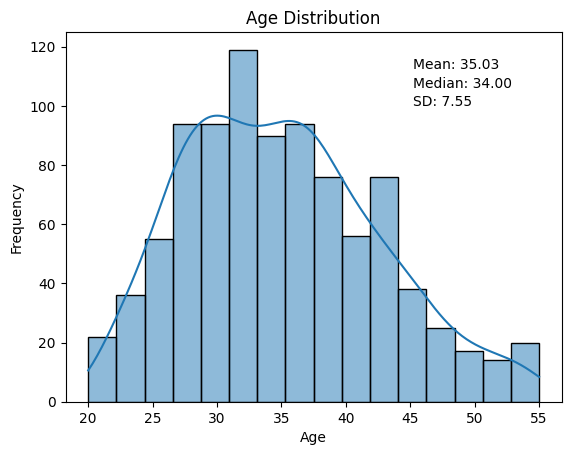

In [37]:
# age distrbution
sns.histplot(data=df, x='age', kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

mean_age = df['age'].mean()
median_age = df['age'].median()
std_age = df['age'].std()

plt.text(0.7, 0.9, f'Mean: {mean_age:.2f}', transform=plt.gca().transAxes)
plt.text(0.7, 0.85, f'Median: {median_age:.2f}', transform=plt.gca().transAxes)
plt.text(0.7, 0.8, f'SD: {std_age:.2f}', transform=plt.gca().transAxes)

plt.show()

#### Gender

<Axes: ylabel='Gender'>

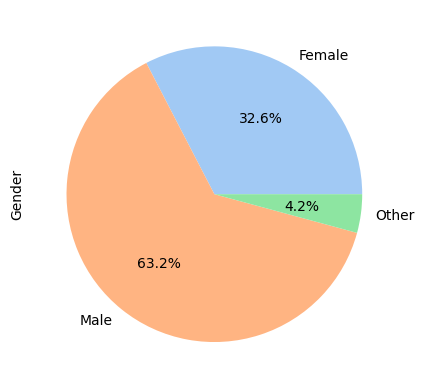

In [38]:
colors = sns.color_palette('pastel')[0:5]
df.groupby(['gender']).size().plot(kind = 'pie', autopct = '%1.1f%%',
                                   label = 'Gender', colors = colors)

Most of the samples come from the USA (80%). For explorative analysis we group the countries. The group "others" is a mix of various countries and not meaningful.

In [39]:
'''
# Group countries into 'Europe', 'United States', and 'Others'
europe_countries = ['United Kingdom', 'Germany', 'Spain', 'France', 'Netherlands', 'Ireland', 'Switzerland', 'Estonia', 'Norway', 'Finland', 'Greece', 'Sweden', 'Poland', 'Portugal', 'Austria']

def categorize_country(country):
    if country == 'United States of America':
        return 'United States'
    elif country in europe_countries:
        return 'Europe'
    else:
        return 'Others'

df['country_group'] = df['country'].apply(categorize_country)

# percentage of individuals with mental health issues within each country group
mental_health_by_country_group = df.groupby('country_group')['mental_health'].value_counts(normalize=True).mul(100).unstack()

display(mental_health_by_country_group)
'''


"\n# Group countries into 'Europe', 'United States', and 'Others'\neurope_countries = ['United Kingdom', 'Germany', 'Spain', 'France', 'Netherlands', 'Ireland', 'Switzerland', 'Estonia', 'Norway', 'Finland', 'Greece', 'Sweden', 'Poland', 'Portugal', 'Austria']\n\ndef categorize_country(country):\n    if country == 'United States of America':\n        return 'United States'\n    elif country in europe_countries:\n        return 'Europe'\n    else:\n        return 'Others'\n\ndf['country_group'] = df['country'].apply(categorize_country)\n\n# percentage of individuals with mental health issues within each country group\nmental_health_by_country_group = df.groupby('country_group')['mental_health'].value_counts(normalize=True).mul(100).unstack()\n\ndisplay(mental_health_by_country_group)\n"

#### Mental Health Status

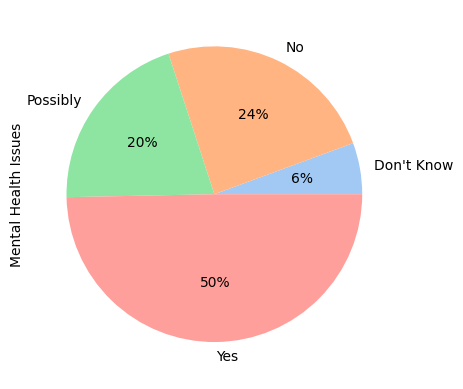

In [40]:
# Mental Health Status overall
df.groupby(['mental_health']).size().plot(kind='pie', autopct='%1.0f%%', label='Mental Health Issues', colors = colors)
plt.show()

#### Mental Health Issues by Gender

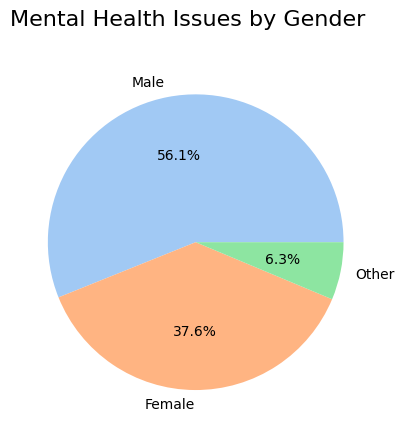

In [41]:
male_with_mental_health = df[(df["mental_health"] == 'Yes') & (df["gender"] == 'Male')]
female_with_mental_health = df[(df["mental_health"] =='Yes') & (df["gender"] == 'Female')]
other_with_mental_health = df[(df["mental_health"] =='Yes') & (df["gender"] == 'Other')]

sizes = [
    male_with_mental_health['gender'].value_counts().get('Male', 0),
    female_with_mental_health['gender'].value_counts().get('Female', 0),
    other_with_mental_health['gender'].value_counts().get('Other', 0),
]
labels = ['Male', 'Female', 'Other']

fig1, ax1 = plt.subplots()
fig1.suptitle('Mental Health Issues by Gender', fontsize=16)
ax1.pie(sizes, labels = labels, autopct = '%1.1f%%', colors = colors)
plt.show()

#### Mental Health by Age and Gender

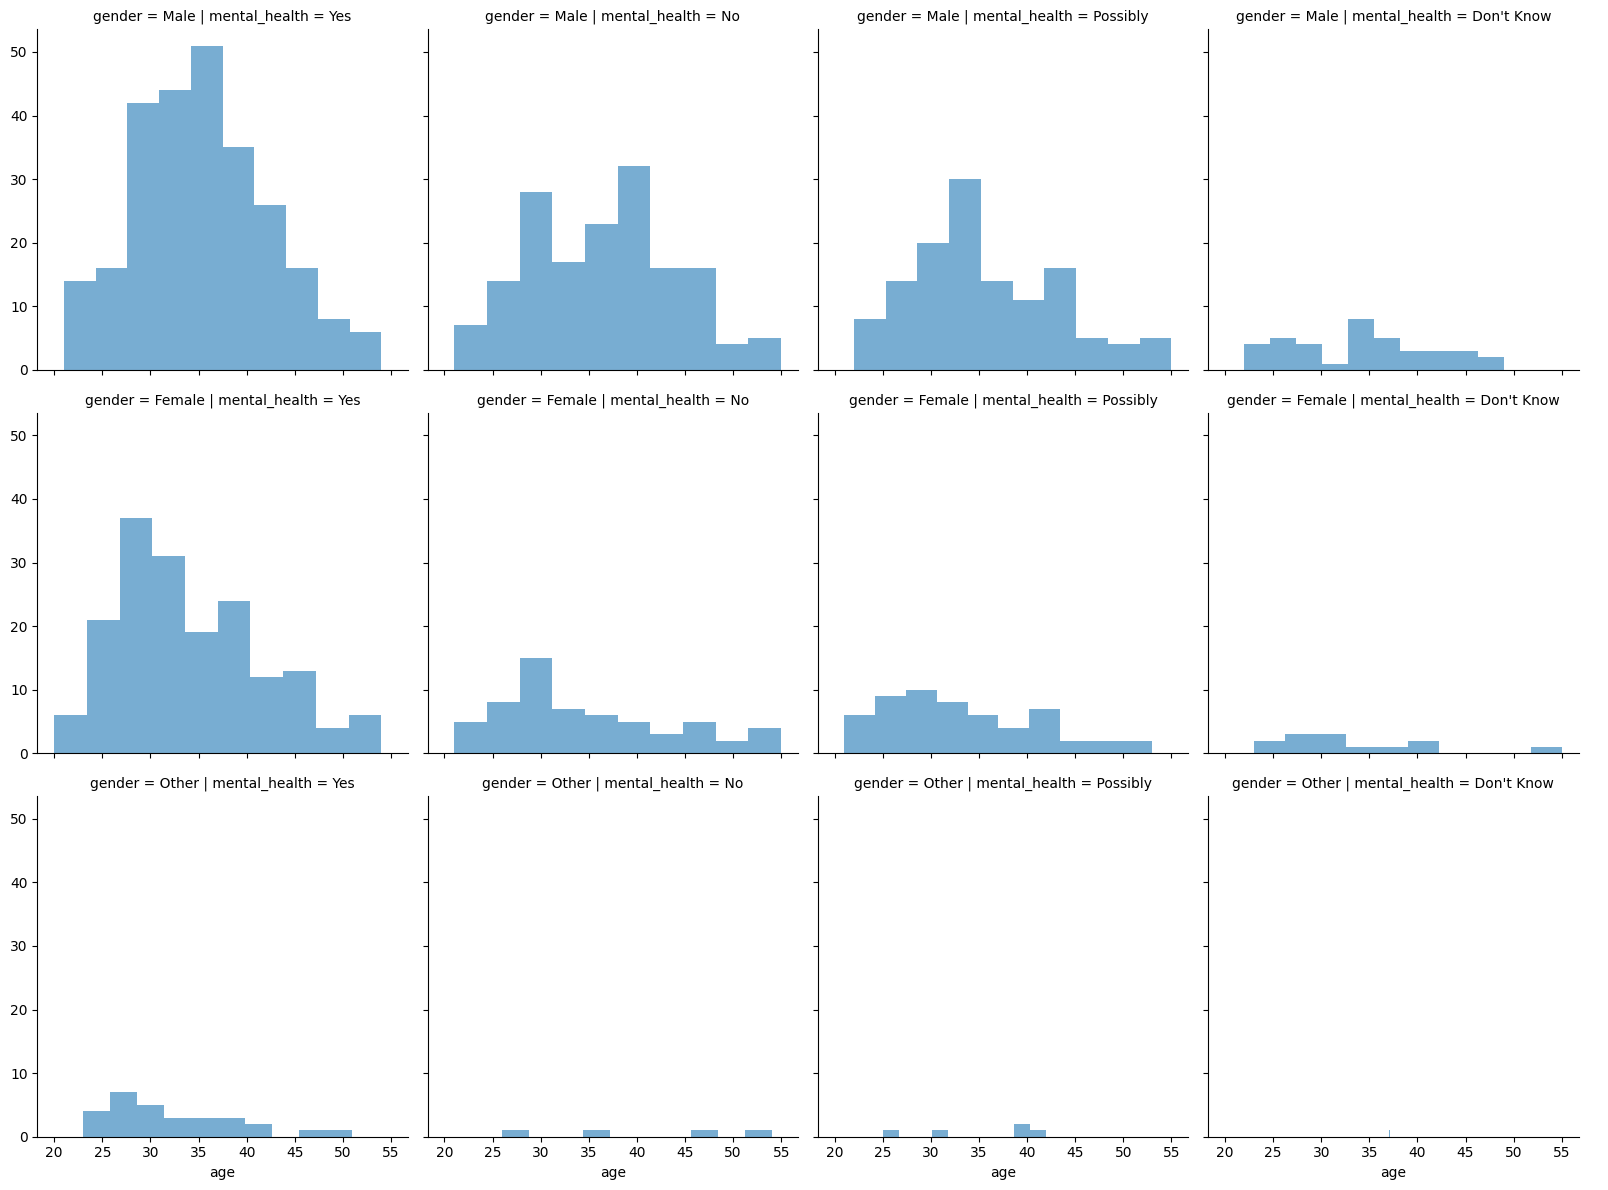

In [42]:
# Plot by Age, Gender and Mental Health

g = sns.FacetGrid(df, row = 'gender', col = 'mental_health', height = 4)
g.map(plt.hist, 'age', bins = 10, alpha = 0.6)
g.add_legend()
plt.show()


#### Average/Median Age for Mental Health Status and Gender

In [43]:
# Mean, median for each gender and their mental health status
average_age_by_gender_and_mh = df.groupby(['gender', 'mental_health'])['age'].agg(['mean', 'median', 'count']).reset_index() # possible features later

# Display the results
display(average_age_by_gender_and_mh)

,gender,mental_health,mean,median,count
0,Female,Don't Know,33.384615,32.0,13
1,Female,No,34.683333,33.0,60
2,Female,Possibly,33.464286,32.0,56
3,Female,Yes,33.895954,33.0,173
4,Male,Don't Know,34.078947,34.5,38
5,Male,No,36.475309,37.0,162
6,Male,Possibly,35.598425,34.0,127
7,Male,Yes,35.480620,35.0,258
8,Other,Don't Know,37.000000,37.0,1
9,Other,No,41.000000,42.0,4


#### Ressources/Benefits for Mental Health Issues


<Axes: ylabel='Health benefits provided '>

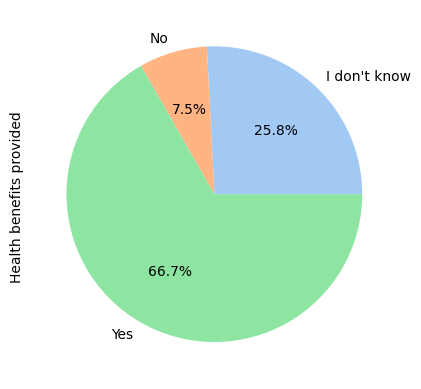

In [44]:
# health benefits provided by employer
df.groupby(['benefits']).size().plot(kind = 'pie', autopct = '%1.1f%%', label = 'Health benefits provided ', colors = colors)

<Axes: ylabel='Mental Health Resources Provided '>

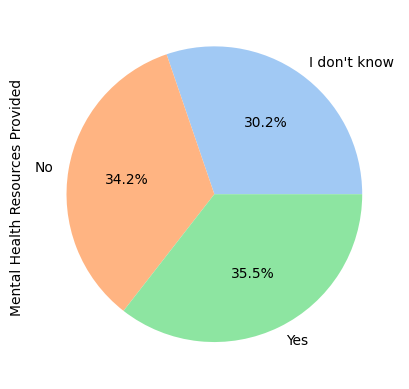

In [45]:
# ressources for mental health provided by employer
df.groupby(['workplace_resources']).size().plot(kind = 'pie', autopct = '%1.1f%%', label = 'Mental Health Resources Provided ', colors = colors)

Following observations can be derived from above.

- More than 60% employee have medical coverage provided from employer, but not the resources to get more information, suggesting that companies do not get active involvement.
- Around 12% employee do not have medical coverage.

#### Mental Health Discussion with Employer


<Axes: ylabel='Discuss Mental Health with Employer '>

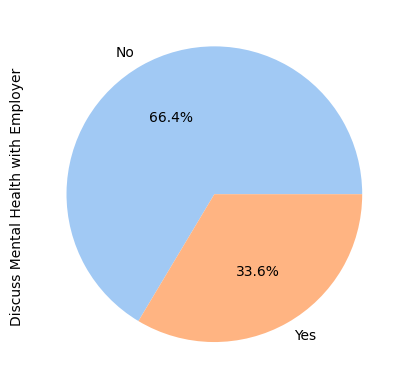

In [46]:
# Discuss mental health with employer
df.groupby(['mh_employer_discussion']).size().plot(kind = 'pie', autopct = '%1.1f%%', label = 'Discuss Mental Health with Employer ', colors = colors)

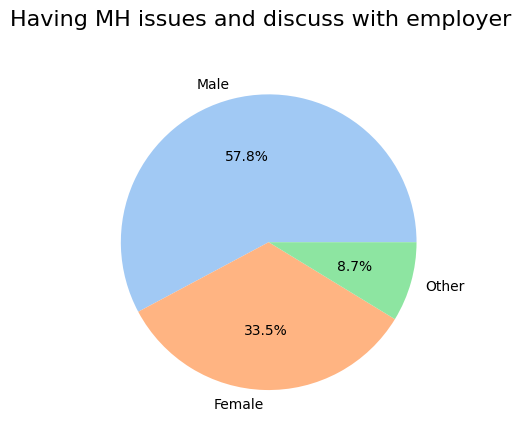

In [47]:
# Employees with mental health issue who discuss it with their employer
male_has_mh_and_not_discussed = df[(df["mental_health"] == 'Yes') & (df["gender"] == 'Male') & (df["mh_employer_discussion"] == 'Yes')]
female_has_mh_and_not_discussed = df[(df["mental_health"] =='Yes') & (df["gender"] == 'Female') & (df["mh_employer_discussion"] == 'Yes')]
other_has_mh_and_not_discussed = df[(df["mental_health"] =='Yes') & (df["gender"] == 'Other') & (df["mh_employer_discussion"] == 'Yes')]

sizes = [
    male_has_mh_and_not_discussed['gender'].value_counts().get('Male', 0),
    female_has_mh_and_not_discussed['gender'].value_counts().get('Female', 0),
    other_has_mh_and_not_discussed['gender'].value_counts().get('Other', 0),
]
labels = ['Male', 'Female', 'Other']

fig1, ax1 = plt.subplots()
fig1.suptitle('Having MH issues and discuss with employer', fontsize=16)
ax1.pie(sizes, labels = labels, autopct = '%1.1f%%', colors = colors)
plt.show()

#### Mental Health Discussion with Coworkers

<Axes: ylabel='Discuss Mental Health with Co-Workers '>

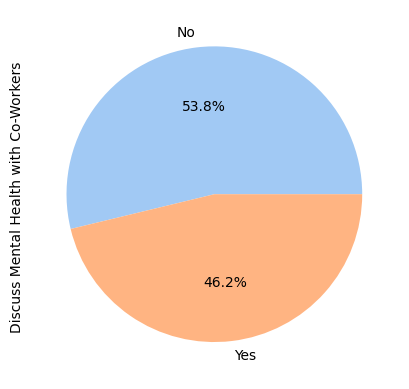

In [48]:
df.groupby(['mh_coworker_discussion']).size().plot(kind = 'pie', autopct = '%1.1f%%', label = 'Discuss Mental Health with Co-Workers ', colors = colors)

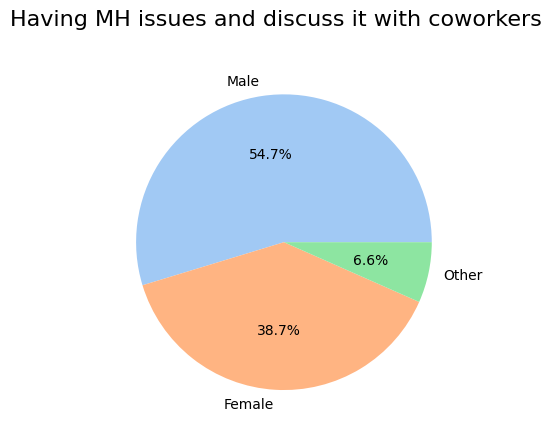

In [49]:
male_has_mh_and_not_discussed = df[(df["mental_health"] == 'Yes') & (df["gender"] == 'Male') & (df["mh_coworker_discussion"] == 'Yes')]
female_has_mh_and_not_discussed = df[(df["mental_health"] =='Yes') & (df["gender"] == 'Female') & (df["mh_coworker_discussion"] == 'Yes')]
other_has_mh_and_not_discussed = df[(df["mental_health"] =='Yes') & (df["gender"] == 'Other') & (df["mh_coworker_discussion"] == 'Yes')]

sizes = [
    male_has_mh_and_not_discussed['gender'].value_counts().get('Male', 0),
    female_has_mh_and_not_discussed['gender'].value_counts().get('Female', 0),
    other_has_mh_and_not_discussed['gender'].value_counts().get('Other', 0),
]
labels = ['Male', 'Female', 'Other']

fig1, ax1 = plt.subplots()
fig1.suptitle('Having MH issues and discuss it with coworkers', fontsize=16)
ax1.pie(sizes, labels = labels, autopct = '%1.1f%%', colors = colors)
plt.show()

In [50]:
# cross-tabulation of mh_employer_discussion and mh_coworker_discussion
discussion_comparison_table = pd.crosstab(df['mh_coworker_discussion'], df['mh_employer_discussion'])

display(discussion_comparison_table)

mh_employer_discussion,No,Yes
mh_coworker_discussion,,
No,429,69
Yes,186,242


#### Wllingness Sharing Mental Heatlh with Family/Friends

Median of mh_share: 7.0


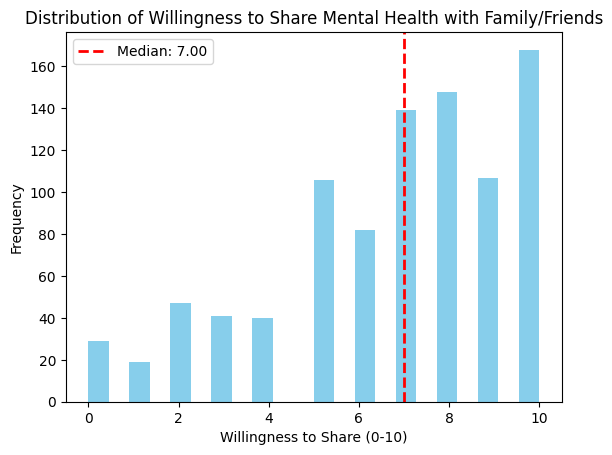

In [51]:
# Calculate the median of mh_share
median_mh_share = df['mh_share'].median()
print(f"Median of mh_share: {median_mh_share}")

# Create a histogram of mh_share
plt.hist(df['mh_share'], bins=22, color="skyblue") # ordinal
plt.title('Distribution of Willingness to Share Mental Health with Family/Friends')
plt.xlabel('Willingness to Share (0-10)')
plt.ylabel('Frequency')

# Add a vertical line at the median
plt.axvline(median_mh_share, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_mh_share:.2f}')
plt.legend()

plt.show()

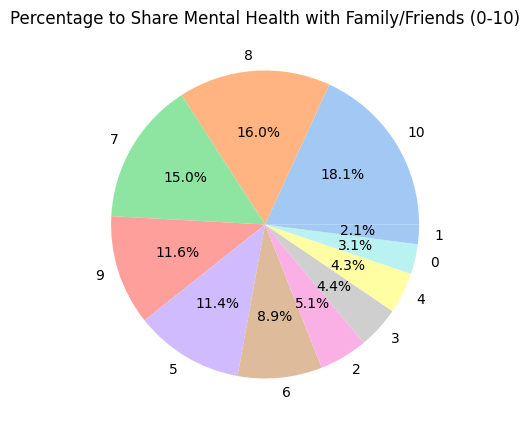

In [52]:
# Share Mental Health with Family/Friends
df['mh_share'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5, 5), colors=sns.color_palette('pastel'))
plt.title('Percentage to Share Mental Health with Family/Friends (0-10)')
plt.ylabel('') # Remove default ylabel
plt.show()

### Feature Engineering



In [53]:
# dtypes
df.dtypes

,0
tech_company,object
benefits,object
workplace_resources,object
mh_employer_discussion,object
mh_coworker_discussion,object
medical_coverage,object
mental_health,object
mh_share,int64
age,float64
gender,object


#### Binary Encoding

In [54]:
# store unencoded
df_raw = df.copy()


In [55]:
df.nunique()

,0
tech_company,2
benefits,3
workplace_resources,3
mh_employer_discussion,2
mh_coworker_discussion,2
medical_coverage,2
mental_health,4
mh_share,11
age,36
gender,3


In [56]:
binary_cols = ['tech_company','mh_employer_discussion','mh_coworker_discussion','medical_coverage']
df[binary_cols] = df[binary_cols].replace({'Yes': 1, 'No': 0})

/tmp/ipython-input-984717863.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace({'Yes': 1, 'No': 0})


In [57]:
df_copy_with_country = df.copy()
df.drop(columns = ['country'], inplace = True)

#### Binning Age

In [58]:
# Binning into age groups
age_bins = [18, 25, 35, 45, 55]
age_labels = ['18-24','25-34','35-44','45-55']
df['age_groups'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

#### Binning mh_share

In [59]:
# binning to low, medium, high
mh_bins = [0, 3, 7, 10]
mh_labels = ['low','medium','high']
df['mh_share_group'] = pd.cut(df['mh_share'], bins=mh_bins, labels=mh_labels)


#### Interaction Feautures

In [60]:
# Age
df['age_mh_share'] = df['age'] * df['mh_share']
df['age_employer'] = df['age'] * df['mh_employer_discussion']
df['age_coworker'] = df['age'] * df['mh_coworker_discussion']
df['age_tech'] = df['age'] * df['tech_company']

# medical coverage
df['mh_share_employer'] = df['mh_share'] * df['mh_employer_discussion']
df['mh_share_coworker'] = df['mh_share'] * df['mh_coworker_discussion']
df['mh_share_medical'] = df['mh_share'] * df['medical_coverage']
df['mh_share_tech'] = df['mh_share'] * df['tech_company']
df['mh_share_benefits'] = df['mh_share'] * df['benefits']
df['mh_share_resources'] = df['mh_share'] * df['workplace_resources']

# workplace features
df['mh_discussion_both'] = df['mh_employer_discussion'] * df['mh_coworker_discussion']

# Tech company and medical coverage
df['tech_medical'] = df['tech_company'] * df['medical_coverage']

# Tech company and coworker discussion
df['tech_mh_coworker'] = df['tech_company'] * df['mh_coworker_discussion']

# aggregation
# Total discussions
df['mh_discussion_total'] = df['mh_employer_discussion'] + df['mh_coworker_discussion']

# Any discussion flag
df['mh_discussion_any'] = (df['mh_discussion_total'] > 0).astype(int)

# Total resources
df['num_perks'] = df['benefits'] + df['workplace_resources']

# create binary features for specific columns
df['benefits_binary'] = df['benefits'].apply(lambda x: 1 if x == 'Yes' else 'No')
df['workplace_resources_binary'] = df['workplace_resources'].apply(lambda x: 1 if x == 'Yes' else 0)
df['mental_health_binary'] = df['mental_health'].apply(lambda x: 1 if x == 'Yes' else 0)

In [61]:
df.nunique()

,0
tech_company,2
benefits,3
workplace_resources,3
mh_employer_discussion,2
mh_coworker_discussion,2
medical_coverage,2
mental_health,4
mh_share,11
age,36
gender,3


In [62]:
# Encode 'Yes' and 'No' to 1 and 0 for new features
cols_to_encode = ['benefits_binary','workplace_resources_binary', 'mental_health_binary']
for col in cols_to_encode:
    df[col] = df[col].replace({'Yes': 1, 'No': 0})

df

/tmp/ipython-input-3424744787.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'Yes': 1, 'No': 0})


,tech_company,benefits,workplace_resources,mh_employer_discussion,mh_coworker_discussion,medical_coverage,mental_health,mh_share,age,gender,...,mh_share_resources,mh_discussion_both,tech_medical,tech_mh_coworker,mh_discussion_total,mh_discussion_any,num_perks,benefits_binary,workplace_resources_binary,mental_health_binary
2,1,I don't know,No,1,1,0,Yes,5,36.0,Male,...,NoNoNoNoNo,1,0,1,2,1,I don't knowNo,0,0,1
3,1,Yes,I don't know,1,1,1,Yes,10,22.0,Male,...,I don't knowI don't knowI don't knowI don't kn...,1,1,1,2,1,YesI don't know,1,0,1
6,1,Yes,No,0,1,1,Yes,8,36.0,Female,...,NoNoNoNoNoNoNoNo,0,1,1,1,1,YesNo,1,0,1
7,1,Yes,No,0,0,1,No,3,38.0,Female,...,NoNoNo,0,1,0,0,0,YesNo,1,0,0
10,0,Yes,No,1,1,1,Yes,2,40.0,Male,...,NoNo,1,0,0,2,1,YesNo,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818,1,I don't know,No,0,0,0,Possibly,8,45.0,Male,...,NoNoNoNoNoNoNoNo,0,0,0,0,0,I don't knowNo,0,0,0
1821,0,I don't know,No,0,1,0,Yes,0,45.0,Male,...,,0,0,0,1,1,I don't knowNo,0,0,1
1822,0,Yes,Yes,0,0,1,Yes,10,30.0,Female,...,YesYesYesYesYesYesYesYesYesYes,0,0,0,0,0,YesYes,1,1,1
1827,0,Yes,Yes,1,1,1,Yes,9,35.0,Male,...,YesYesYesYesYesYesYesYesYes,1,0,0,2,1,YesYes,1,1,1


#### One-hot encoding

In [63]:
# Get categorical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()

print("Categorical columns:", categorical_cols)

Categorical columns: ['benefits', 'workplace_resources', 'mental_health', 'gender', 'mh_share_benefits', 'mh_share_resources', 'num_perks']


In [64]:
df1 = df.copy()

In [65]:
one_hot_cols = ['benefits','workplace_resources','gender','mental_health','mh_share_group','age_groups','mh_share_benefits',# interaction features
               'mh_share_resources','num_perks'] #,'country_group' without
one_hot_cols2= ['benefits', 'workplace_resources', 'mental_health', 'gender','mh_share_group','age_groups'] # without interaction features

encoded_cols = pd.get_dummies(df1[one_hot_cols], prefix=one_hot_cols, dtype=int)

df2 = pd.concat([df1, encoded_cols], axis=1)
df2.drop(columns=one_hot_cols, inplace=True)
df2.head()

,tech_company,mh_employer_discussion,mh_coworker_discussion,medical_coverage,mh_share,age,age_mh_share,age_employer,age_coworker,age_tech,...,mh_share_resources_YesYesYesYesYesYesYesYesYesYes,num_perks_I don't knowI don't know,num_perks_I don't knowNo,num_perks_I don't knowYes,num_perks_NoI don't know,num_perks_NoNo,num_perks_NoYes,num_perks_YesI don't know,num_perks_YesNo,num_perks_YesYes
2,1,1,1,0,5,36.0,180.0,36.0,36.0,36.0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,1,1,10,22.0,220.0,22.0,22.0,22.0,...,0,0,0,0,0,0,0,1,0,0
6,1,0,1,1,8,36.0,288.0,0.0,36.0,36.0,...,0,0,0,0,0,0,0,0,1,0
7,1,0,0,1,3,38.0,114.0,0.0,0.0,38.0,...,0,0,0,0,0,0,0,0,1,0
10,0,1,1,1,2,40.0,80.0,40.0,40.0,0.0,...,0,0,0,0,0,0,0,0,1,0


###Feature Selection

In [66]:
# check unqiue values
# we have some interaction features that will dominate in variance
df.nunique()

,0
tech_company,2
benefits,3
workplace_resources,3
mh_employer_discussion,2
mh_coworker_discussion,2
medical_coverage,2
mental_health,4
mh_share,11
age,36
gender,3


#### Scaling

In [68]:
# Columns to scale with MinMax
cols_to_scale = [
    'mh_share', 'age', 'age_employer', 'age_coworker', 'age_tech',
    'mh_share_employer', 'mh_share_coworker', 'mh_share_medical',
    'age_mh_share', 'mh_share_tech', 'mh_discussion_total'
]

# Binary columns untouched
binary_cols = [col for col in df.columns if df[col].nunique() == 2]

# Columns for MinMax scaling
cols_minmax = [col for col in cols_to_scale if col not in binary_cols]

df_scaled = df2.copy()

# MinMaxScaler
minmax_scaler = MinMaxScaler()
df_scaled[cols_minmax] = minmax_scaler.fit_transform(df_scaled[cols_minmax])

print("Scaled DataFrame:")
display(df_scaled.head())


Scaled DataFrame:


,tech_company,mh_employer_discussion,mh_coworker_discussion,medical_coverage,mh_share,age,age_mh_share,age_employer,age_coworker,age_tech,...,mh_share_resources_YesYesYesYesYesYesYesYesYesYes,num_perks_I don't knowI don't know,num_perks_I don't knowNo,num_perks_I don't knowYes,num_perks_NoI don't know,num_perks_NoNo,num_perks_NoYes,num_perks_YesI don't know,num_perks_YesNo,num_perks_YesYes
2,1,1,1,0,0.5,0.457143,0.339623,0.666667,0.666667,0.654545,...,0,0,1,0,0,0,0,0,0,0
3,1,1,1,1,1.0,0.057143,0.415094,0.407407,0.407407,0.400000,...,0,0,0,0,0,0,0,1,0,0
6,1,0,1,1,0.8,0.457143,0.543396,0.000000,0.666667,0.654545,...,0,0,0,0,0,0,0,0,1,0
7,1,0,0,1,0.3,0.514286,0.215094,0.000000,0.000000,0.690909,...,0,0,0,0,0,0,0,0,1,0
10,0,1,1,1,0.2,0.571429,0.150943,0.740741,0.740741,0.000000,...,0,0,0,0,0,0,0,0,1,0


#### Principal Component Analysis

###### PCA Scaled Data

In [69]:
# PCA on scaled data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

# Create a new DataFrame with the PCA components
X_pca_df = pd.DataFrame(data = X_pca, columns = ['pca_1', 'pca_2'])

loadings = pd.DataFrame(pca.components_[0], index=df2.columns, columns=["PC1"])
display(loadings.sort_values("PC1", key=abs, ascending=False))
print("Explained variance ratio:", pca.explained_variance_ratio_)


,PC1
mh_coworker_discussion,0.290641
mh_discussion_any,0.287775
mh_discussion_total,0.267154
mh_share_coworker,0.249646
tech_mh_coworker,0.248039
...,...
mh_share_benefits_NoNoNoNoNoNoNoNoNo,0.001019
mh_share_resources_YesYesYesYes,-0.000918
mh_share_benefits_NoNoNoNoNoNo,-0.000851
mh_share_resources_YesYesYesYesYes,-0.000571


Explained variance ratio: [0.18950484 0.09770943]


###### PCA not scaled

In [70]:
# PCA on not scaled data (df2)
pca = PCA(n_components=2)
X_pca_ns = pca.fit_transform(df2)

# Create a new DataFrame with the PCA components
X_pca_unscaled = pd.DataFrame(data = X_pca, columns = ['pca_1', 'pca_2'])

loadings = pd.DataFrame(pca.components_[0], index=df2.columns, columns=["PC1"])
display(loadings.sort_values("PC1", key=abs, ascending=False))
print("Explained variance ratio:", pca.explained_variance_ratio_)

,PC1
age_mh_share,0.995305
age_coworker,0.059148
age_employer,0.049895
age,0.031521
age_tech,0.027857
...,...
mh_share_benefits_NoNoNoNoNoNoNoNo,0.000015
mh_share_benefits_NoNoNoNoNoNo,-0.000011
num_perks_NoYes,0.000010
num_perks_YesNo,0.000006


Explained variance ratio: [0.92850511 0.03217331]


**If the data is not scaled, the clusters are along age, mh_share (willingness to share with friends). In this case this also includes the interaction features based on these features. The scaled data doesnt provide robust clusters in euclidean space.**

### Unsupervised Model

#### K-Means, Agglomerative Clustering w. PCA, no scaling

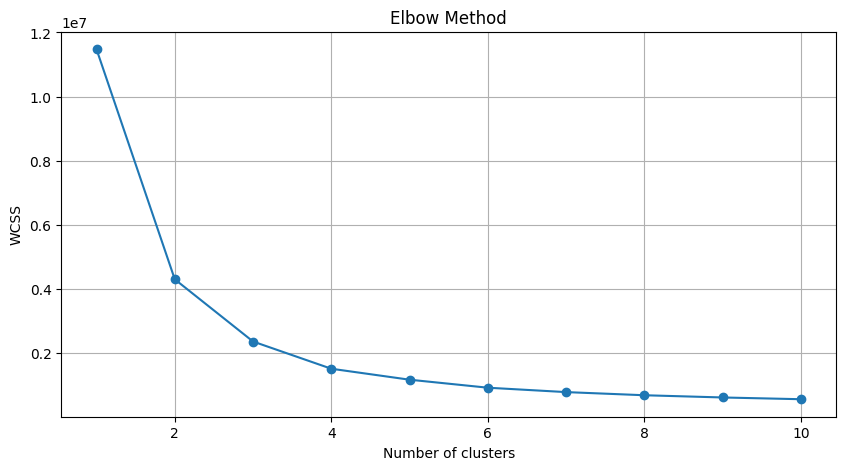

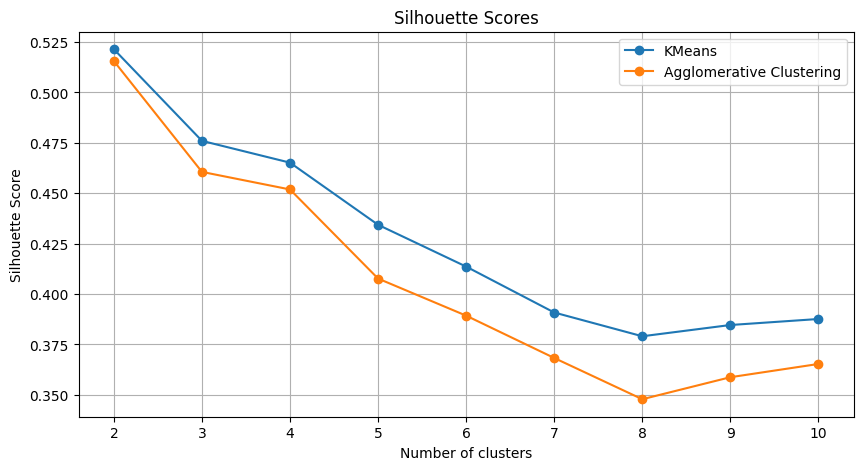

In [71]:
# KMeans
df_ns = X_pca_ns
wcss_kmeans_pca = []
silhouette_scores_kmeans_pca = []
for i in range(1, 11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans_pca.fit(df_ns)
    wcss_kmeans_pca.append(kmeans_pca.inertia_)
    if i > 1:
        score = silhouette_score(df_ns, kmeans_pca.labels_)
        silhouette_scores_kmeans_pca.append(score)

# Agglomerative Clustering
silhouette_scores_agg_pca = []
for n_clusters in range(2, 11):
    agg_clustering_pca = AgglomerativeClustering(n_clusters=n_clusters)
    labels_pca = agg_clustering_pca.fit_predict(df_ns)
    score = silhouette_score(df_ns, labels_pca)
    silhouette_scores_agg_pca.append(score)

# Plotting Elbow Method for KMeans
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss_kmeans_pca, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Plotting Silhouette Scores for clustering
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores_kmeans_pca, marker='o', label='KMeans')
plt.plot(range(2, 11), silhouette_scores_agg_pca, marker='o', label='Agglomerative Clustering')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.legend()
plt.show()

#### K-Means & Agglomerative Clustering with PCA/Scaling

In [72]:
df_pca_reduced = X_pca

# KMeans on PCA reduced data
wcss_kmeans_pca = []
silhouette_scores_kmeans_pca = []
davies_bouldin_scores_kmeans_pca = [] #  Davies-Bouldin
calinski_harabasz_scores_kmeans_pca = [] #  Calinski-Harabasz

K = range(2, 11) # Try a range of cluster numbers

for num_clusters in K:
    kmeans_pca = KMeans(n_clusters=num_clusters, init='k-means++', random_state=42, n_init=10)
    kmeans_pca.fit(df_pca_reduced)
    wcss_kmeans_pca.append(kmeans_pca.inertia_)

    # Calculate evaluation metrics
    labels = kmeans_pca.labels_
    silhouette_scores_kmeans_pca.append(silhouette_score(df_pca_reduced, labels)) # Evaluate on df3
    davies_bouldin_scores_kmeans_pca.append(davies_bouldin_score(df_pca_reduced, labels)) # Added DBI calculation
    calinski_harabasz_scores_kmeans_pca.append(calinski_harabasz_score(df_pca_reduced, labels)) # Added CHI calculation


# Fit KMeans with the chosen number of clusters
# and store the labels in a variable accessible by other cells.
chosen_k = 2 # You can change this based on your preferred number of clusters
final_kmeans_model = KMeans(n_clusters=chosen_k, init='k-means++', random_state=42, n_init=10)
final_kmeans_model.fit(df_pca_reduced)
kmeans_cluster_labels = final_kmeans_model.labels_ # Store labels in a new variable


# Agglomerative Clustering on PCA reduced data
silhouette_scores_agg_pca = []
davies_bouldin_scores_agg_pca = [] # Added Davies-Bouldin scores list
calinski_harabasz_scores_agg_pca = [] # Added Calinski-Harabasz scores list

for n_clusters in range(2, 11):
    # Use 'euclidean' metric for Agglomerative Clustering on PCA reduced data (which is numerical)
    agg_clustering_pca = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward') # Using 'ward' linkage as it's common with Euclidean distance
    labels_pca = agg_clustering_pca.fit_predict(df_pca_reduced) # Fit on df3

    # Calculate evaluation metrics
    silhouette_scores_agg_pca.append(silhouette_score(df_pca_reduced, labels_pca)) # Evaluate on df3
    davies_bouldin_scores_agg_pca.append(davies_bouldin_score(df_pca_reduced, labels_pca)) # Added DBI calculation
    calinski_harabasz_scores_agg_pca.append(calinski_harabasz_score(df_pca_reduced, labels_pca)) # Added CHI calculation


# Print the scores for each model and number of clusters
print("KMeans Clustering Scores:") # Updated title
for i, num_clusters in enumerate(K):
    print(f"Number of Clusters (k) = {num_clusters}:")
    print(f"  WCSS: {wcss_kmeans_pca[i]:.2f}")
    if num_clusters > 1:
        print(f"  Silhouette Score: {silhouette_scores_kmeans_pca[i-1]:.4f}") # Adjust index for scores starting from k=2
        print(f"  Davies-Bouldin Index: {davies_bouldin_scores_kmeans_pca[i-1]:.4f}") # Adjust index
        print(f"  Calinski-Harabasz Index: {calinski_harabasz_scores_kmeans_pca[i-1]:.2f}")
    print("-" * 20)

print("\nAgglomerative Hierarchical Clustering Scores:") # Updated title
for i, num_clusters in enumerate(range(2, 11)):
     print(f"Number of Clusters (k) = {num_clusters}:")
     print(f"  Silhouette Score: {silhouette_scores_agg_pca[i]:.4f}")
     print(f"  Davies-Bouldin Index: {davies_bouldin_scores_agg_pca[i]:.4f}")
     print(f"  Calinski-Harabasz Index: {calinski_harabasz_scores_agg_pca[i]:.2f}")
     print("-" * 20)




KMeans Clustering Scores:
Number of Clusters (k) = 2:
  WCSS: 1301.97
  Silhouette Score: 0.5288
  Davies-Bouldin Index: 0.6182
  Calinski-Harabasz Index: 1798.96
--------------------
Number of Clusters (k) = 3:
  WCSS: 823.03
  Silhouette Score: 0.4462
  Davies-Bouldin Index: 0.9155
  Calinski-Harabasz Index: 922.44
--------------------
Number of Clusters (k) = 4:
  WCSS: 521.21
  Silhouette Score: 0.4731
  Davies-Bouldin Index: 0.7020
  Calinski-Harabasz Index: 997.37
--------------------
Number of Clusters (k) = 5:
  WCSS: 378.11
  Silhouette Score: 0.5169
  Davies-Bouldin Index: 0.6732
  Calinski-Harabasz Index: 1226.82
--------------------
Number of Clusters (k) = 6:
  WCSS: 291.50
  Silhouette Score: 0.4946
  Davies-Bouldin Index: 0.7279
  Calinski-Harabasz Index: 1354.18
--------------------
Number of Clusters (k) = 7:
  WCSS: 242.56
  Silhouette Score: 0.5068
  Davies-Bouldin Index: 0.7124
  Calinski-Harabasz Index: 1458.28
--------------------
Number of Clusters (k) = 8:
  WCS

#### K-Means Clusters (k=4, best model)

In [73]:
kmeans_model_k4 = KMeans(n_clusters=4,
                         init='k-means++',
                         random_state=42,
                         n_init=10)
kmeans_model_k4.fit(X_pca)


kmeans_labels_k4 = kmeans_model_k4.labels_

print("KMeans model with k=4 fitted successfully on X_pca.")
print("Cluster labels are stored in the 'kmeans_labels_k4' variable.")

# Calculate evaluation metrics for k=4
silhouette_avg = silhouette_score(X_pca, kmeans_labels_k4)
davies_bouldin_avg = davies_bouldin_score(X_pca, kmeans_labels_k4)
calinski_harabasz_avg = calinski_harabasz_score(X_pca, kmeans_labels_k4)

# Print the scores for k=4
print(f"K-Means K = 4")
print(f"  Silhouette Score: {silhouette_avg:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_avg:.4f}")
print(f"  Calinski-Harabasz Index: {calinski_harabasz_avg:.2f}")

KMeans model with k=4 fitted successfully on X_pca.
Cluster labels are stored in the 'kmeans_labels_k4' variable.
K-Means K = 4
  Silhouette Score: 0.5169
  Davies-Bouldin Index: 0.6732
  Calinski-Harabasz Index: 1226.82


###### T-SNE

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


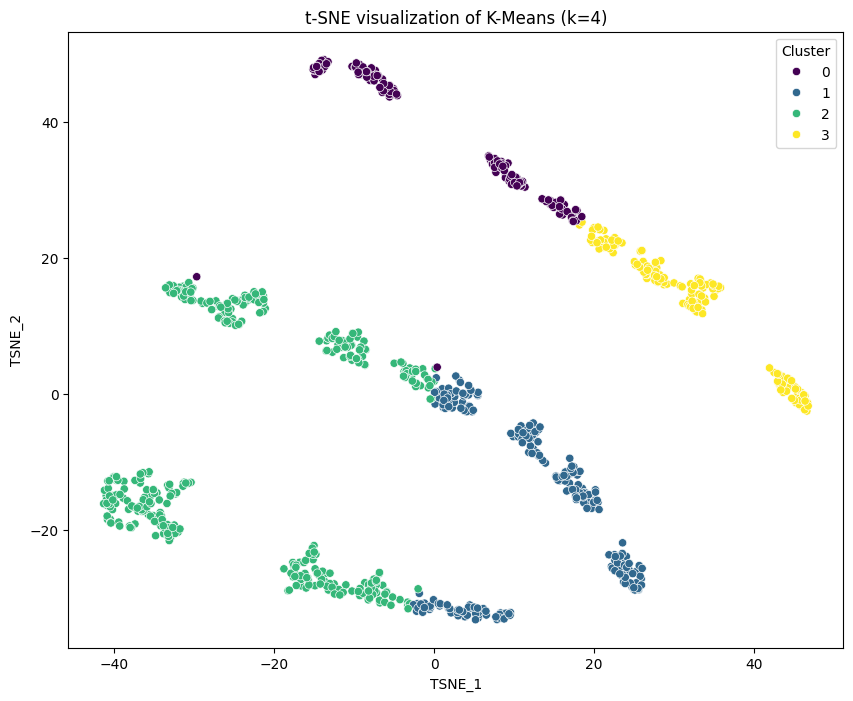

In [74]:
# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2,
            perplexity=30,
            learning_rate=200,
            n_iter=1000,
            random_state=42)

tsne_components = tsne.fit_transform(X_pca)

# Create a DataFrame for the t-SNE components and cluster labels
tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE_1', 'TSNE_2'])
tsne_df['Cluster'] = kmeans_labels_k4

# Visualize the clusters using t-SNE
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Cluster', data=tsne_df, palette='viridis', legend='full')
plt.title('t-SNE visualization of K-Means (k=4)')
plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')
plt.show()

###### Cluster Analysis K-Means

Cluster Summary Table (Mean of Numerical Features and Percentage of Categorical Features):


,age,mh_share,gender_Female,gender_Male,gender_Other,mental_health_Don't Know,mental_health_No,mental_health_Possibly,mental_health_Yes,benefits_I don't know,...,mh_coworker_discussion_0,mh_coworker_discussion_1,medical_coverage_0,medical_coverage_1,tech_company_0,tech_company_1,mental_health_binary_0,mental_health_binary_1,benefits_binary_0,benefits_binary_1
KMeans Cluster,,,,,,,,,,,,,,,,,,,,,
0,35.607143,6.235714,33.571429,65.000000,1.428571,7.857143,40.000000,23.571429,28.571429,0.714286,...,85.000000,15.000000,0.000000,100.000000,47.857143,52.142857,71.428571,28.571429,1.428571,98.571429
1,34.787755,7.922449,34.285714,60.000000,5.714286,2.040816,8.979592,18.367347,70.612245,18.367347,...,8.979592,91.020408,6.122449,93.877551,15.918367,84.081633,29.387755,70.612245,28.571429,71.428571
2,34.772251,5.534031,27.225131,69.895288,2.879581,8.900524,35.078534,23.821990,32.198953,50.523560,...,91.884817,8.115183,20.680628,79.319372,30.366492,69.633508,67.801047,32.198953,61.780105,38.219895
3,35.528302,8.113208,42.138365,50.314465,7.547170,1.257862,8.805031,11.949686,77.987421,0.000000,...,3.773585,96.226415,0.000000,100.000000,20.125786,79.874214,22.012579,77.987421,0.000000,100.000000


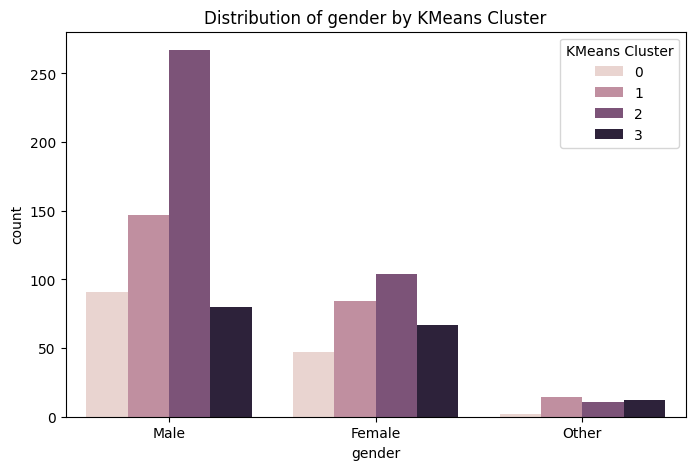

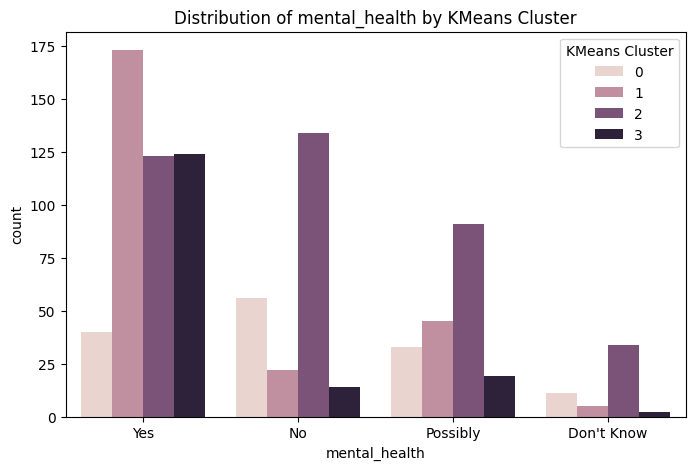

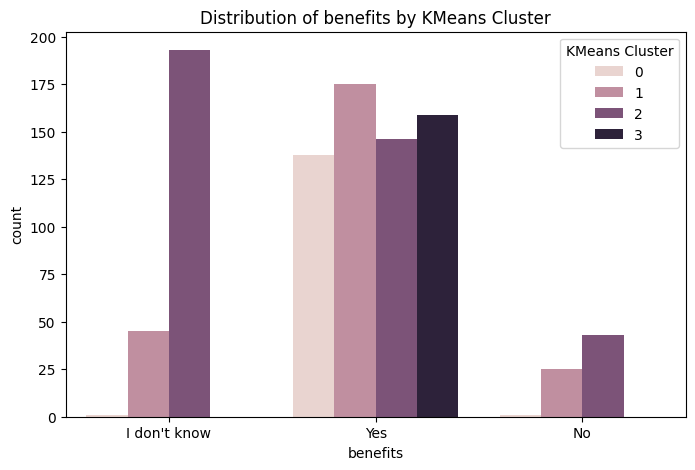

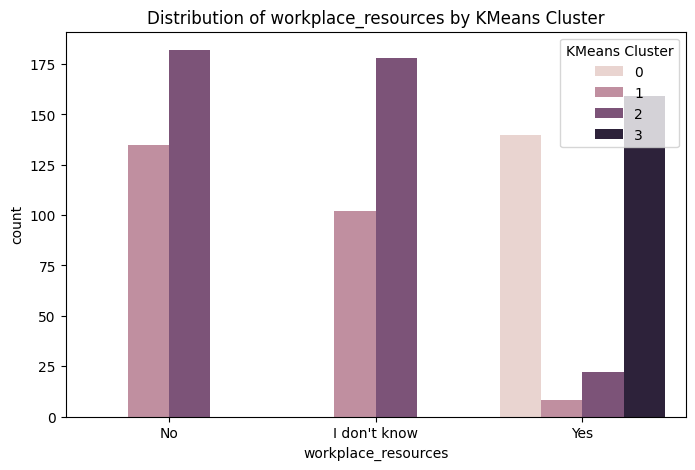

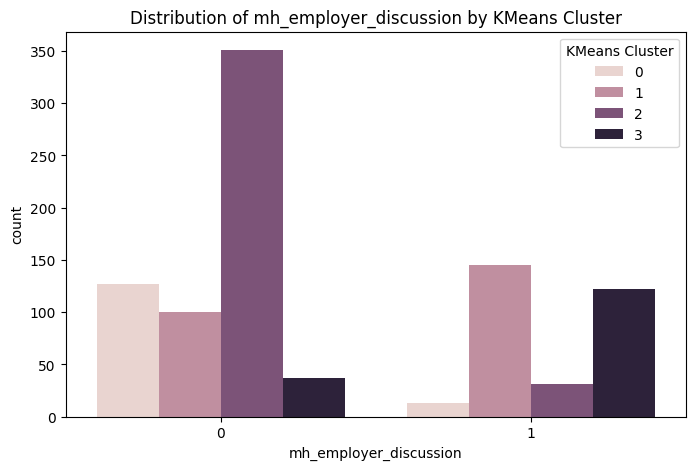

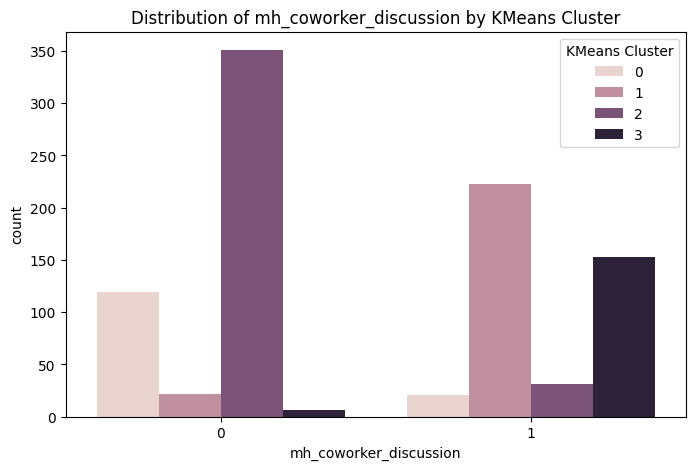

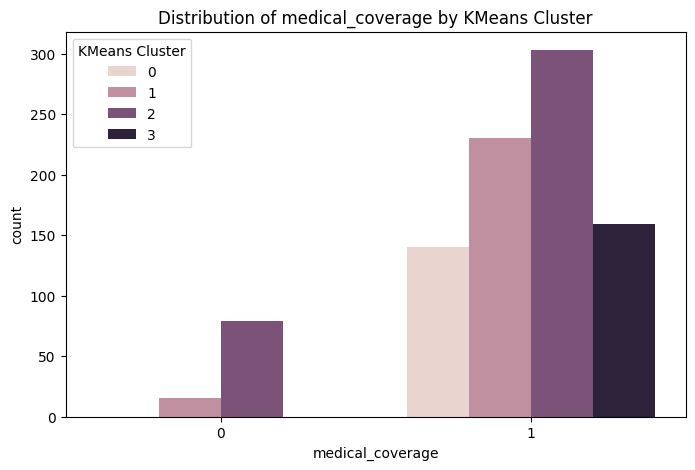

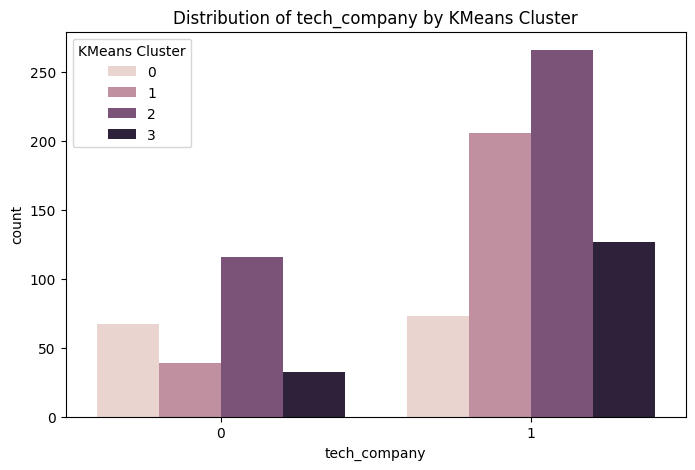

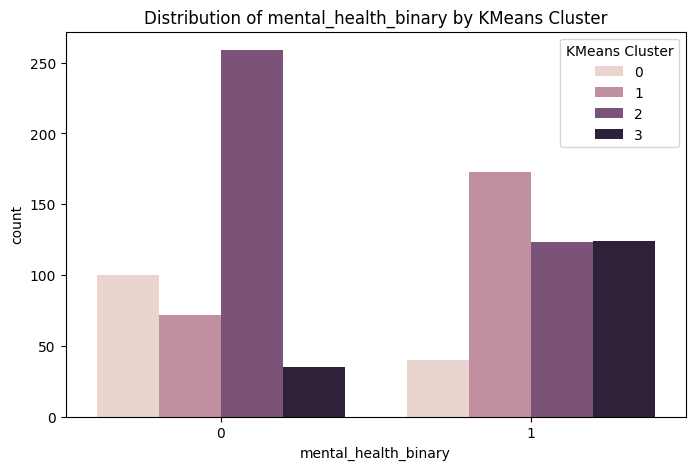

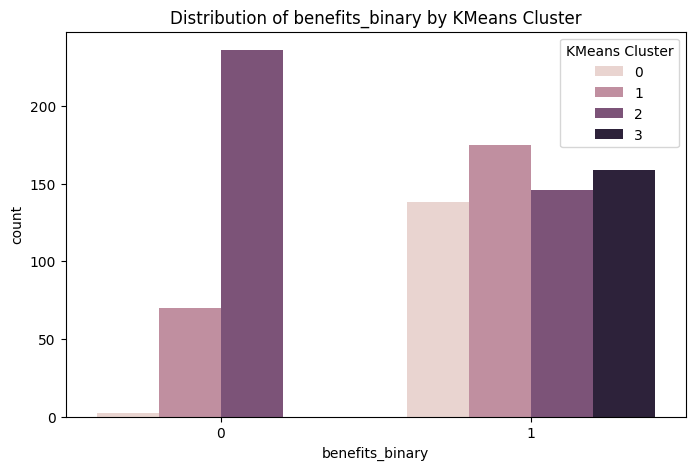

In [85]:
df_with_clusters = df.copy()
df_with_clusters['KMeans Cluster'] = kmeans_labels_k4

# numerical features by cluster
numerical_features_to_analyze = ['age', 'mh_share']
cluster_numerical_means = df_with_clusters.groupby('KMeans Cluster')[numerical_features_to_analyze].mean()

# categorical features by cluster
categorical_features_to_analyze = ['gender', 'mental_health', 'benefits', 'workplace_resources', 'mh_employer_discussion',
                                   'mh_coworker_discussion', 'medical_coverage','tech_company','mental_health_binary',
                                   'benefits_binary'] # ,'country_group' exluded

# distribution
cluster_categorical_distribution = {}
for col in categorical_features_to_analyze:
    # frequency and normalize
    distribution = df_with_clusters.groupby('KMeans Cluster')[col].value_counts(normalize=True).mul(100).unstack(fill_value=0)
    cluster_categorical_distribution[col] = distribution

# numerical means
cluster_summary_table = cluster_numerical_means.copy()

# categorical distributions
for col, distribution_df in cluster_categorical_distribution.items():
    # Rename columns
    distribution_df.columns = [f'{col}_{cat}' for cat in distribution_df.columns]

    # summary table
    cluster_summary_table = cluster_summary_table.join(distribution_df)


print("Cluster Summary Table (Mean of Numerical Features and Percentage of Categorical Features):")
display(cluster_summary_table)



for col in categorical_features_to_analyze:
  plt.figure(figsize=(8, 5))
  sns.countplot(data=df_with_clusters, x=col, hue='KMeans Cluster')
  plt.title(f'Distribution of {col} by KMeans Cluster')
  plt.show()

In [76]:
# Interpretable tables in the cluster table
# binary percentage is 100.0
columns_interpretation = ["age","gender_Male",'gender_Female','gender_Other',"mh_share",'mental_health_Yes',
                          'workplace_resources_Yes','benefits_Yes','tech_company_1', 'mh_coworker_discussion_1',
                          'mh_employer_discussion_1','mental_health_Possibly','mental_health_No'] #,'country_group_United States','country_group_Europe' exluded
cluster_summary_table[columns_interpretation]

,age,gender_Male,gender_Female,gender_Other,mh_share,mental_health_Yes,workplace_resources_Yes,benefits_Yes,tech_company_1,mh_coworker_discussion_1,mh_employer_discussion_1,mental_health_Possibly,mental_health_No
KMeans Cluster,,,,,,,,,,,,,
0,35.607143,65.000000,33.571429,1.428571,6.235714,28.571429,100.000000,98.571429,52.142857,15.000000,9.285714,23.571429,40.000000
1,34.787755,60.000000,34.285714,5.714286,7.922449,70.612245,3.265306,71.428571,84.081633,91.020408,59.183673,18.367347,8.979592
2,34.772251,69.895288,27.225131,2.879581,5.534031,32.198953,5.759162,38.219895,69.633508,8.115183,8.115183,23.821990,35.078534
3,35.528302,50.314465,42.138365,7.547170,8.113208,77.987421,100.000000,100.000000,79.874214,96.226415,76.729560,11.949686,8.805031


#### Cluster Centroids Heatmap

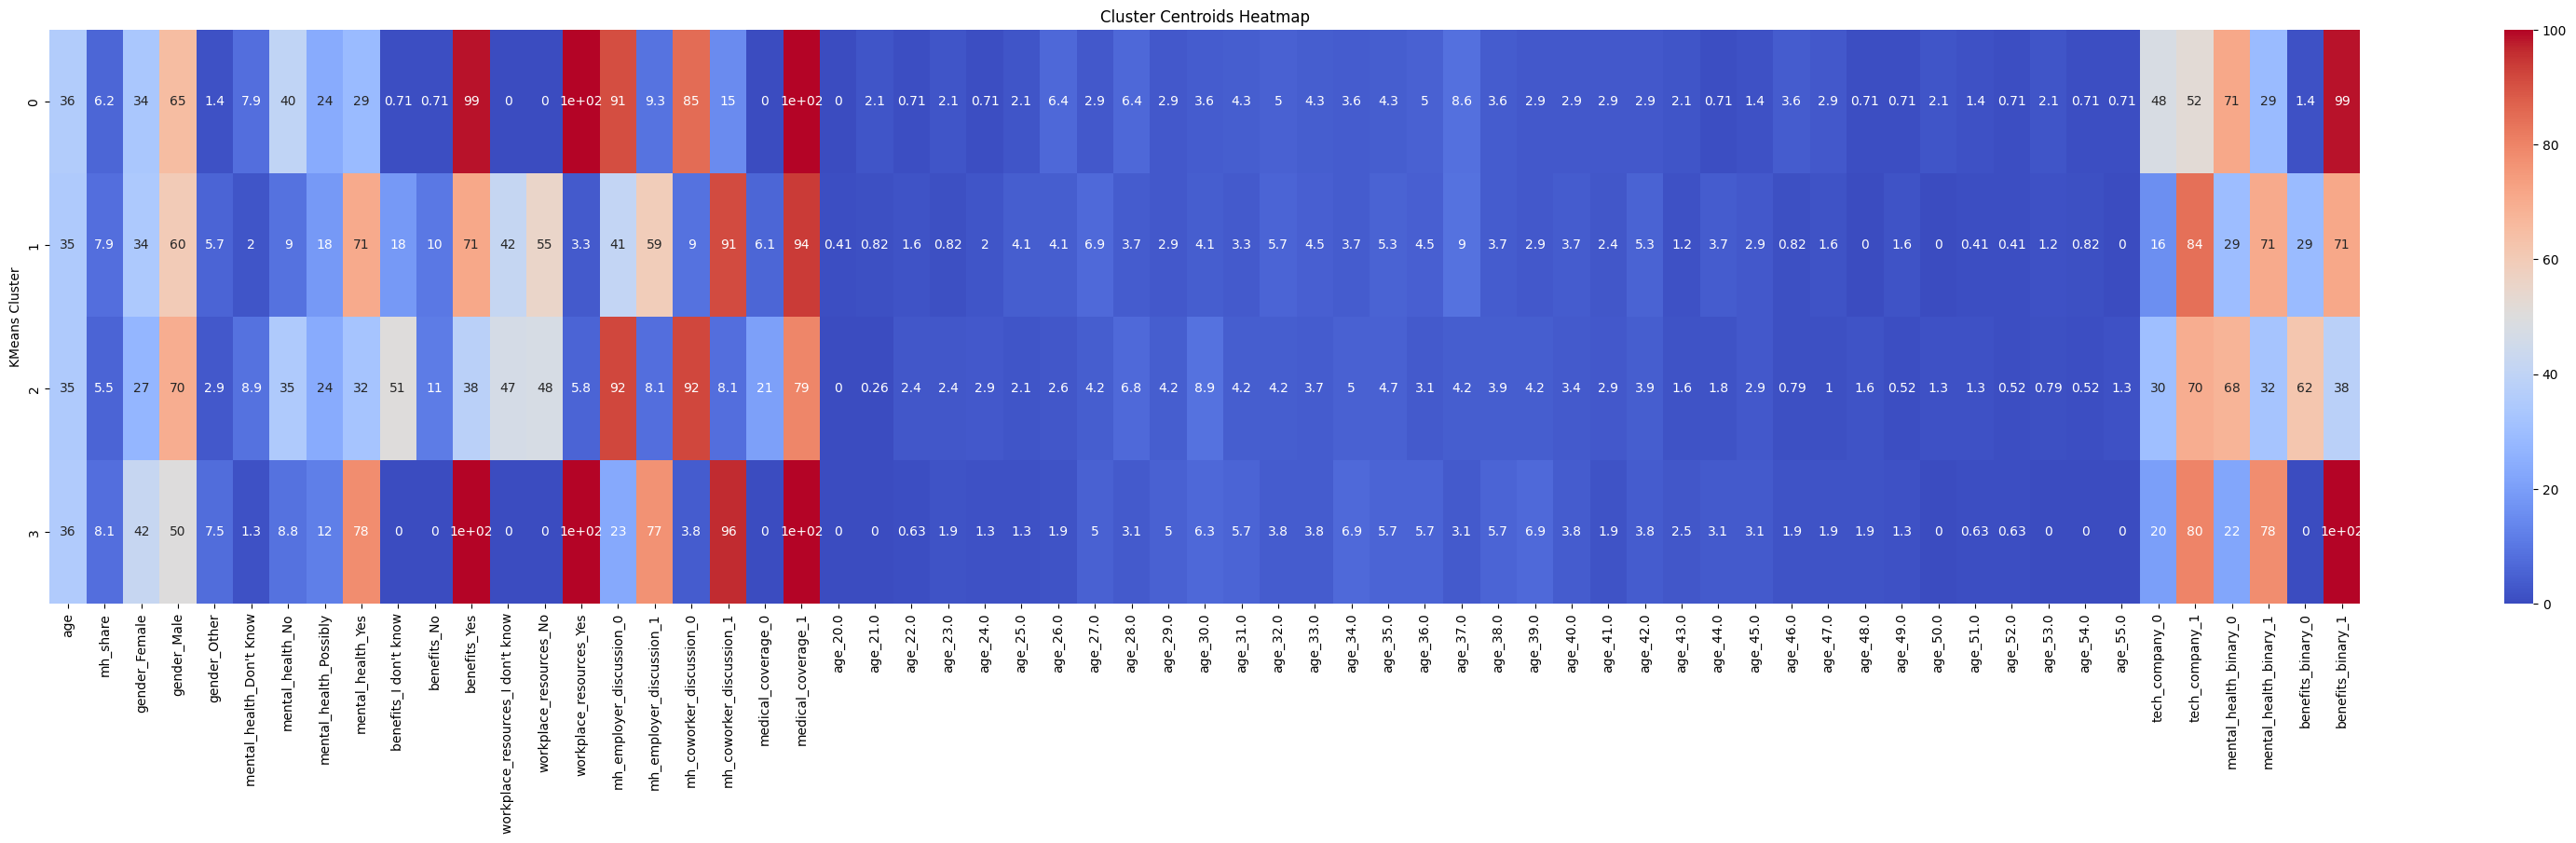

In [77]:
# feature importance
feature_importance1 = cluster_summary_table.max() - cluster_summary_table.min()
feature_importance1.sort_values(ascending=False)

plt.figure(figsize=(40,8))
sns.heatmap(cluster_summary_table, annot=True, cmap='coolwarm')
plt.title("Cluster Centroids Heatmap")
plt.show()



###### Chi Square Test / Anova

In [86]:
# Chi Square test and Anova for p < 0.05
chi_results = []
for var in categorical_features_to_analyze:
    contingency = pd.crosstab(df_with_clusters['KMeans Cluster'], df_with_clusters[var])
    chi2, p_val, dof, _ = chi2_contingency(contingency)
    chi_results.append({'variable': var, 'chi2': chi2, 'p_value': p_val, 'significant': p_val < 0.05})

chi_df = pd.DataFrame(chi_results)
print("Chi-Square Tests:")
print(chi_df)

# ANOVA tests
anova_results = []
for var in numerical_features_to_analyze:
    groups = [df_with_clusters[df_with_clusters['KMeans Cluster'] == i][var] for i in range(4)]
    f_stat, p_val = f_oneway(*groups)
    anova_results.append({'variable': var, 'f_stat': f_stat, 'p_value': p_val, 'significant': p_val < 0.05})

anova_df = pd.DataFrame(anova_results)
print("\nANOVA Tests:")
print(anova_df)

Chi-Square Tests:
                 variable        chi2        p_value  significant
0                  gender   25.129276   3.231376e-04         True
1           mental_health  183.365274   1.004177e-34         True
2                benefits  296.117678   5.553518e-61         True
3     workplace_resources  805.199266  1.158978e-170         True
4  mh_employer_discussion  352.821640   3.653405e-76         True
5  mh_coworker_discussion  635.812266  1.735428e-137         True
6        medical_coverage   84.576060   3.200020e-18         True
7            tech_company   51.573373   3.692544e-11         True
8    mental_health_binary  165.555552   1.158992e-35         True
9         benefits_binary  285.540148   1.339773e-61         True

ANOVA Tests:
   variable     f_stat       p_value  significant
0       age   0.735887  5.307247e-01        False
1  mh_share  67.887401  1.141169e-39         True


#### Agglomerative with Gower Distance (k=4)

In [78]:
# Compute Gower distance
gower_dist = gower.gower_matrix(X_pca)

# Agglomerative Clustering with k=4
n_clusters = 4
agg_clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',  #  distance matrix
    linkage='average'
)
labels = agg_clustering.fit_predict(gower_dist)

# evaluation metrics for k=4
silhouette_avg = silhouette_score(gower_dist, labels, metric='precomputed')
davies_bouldin_avg = davies_bouldin_score(X_pca, labels)
calinski_harabasz_avg = calinski_harabasz_score(X_pca, labels)

# scores for k=4
print(f"Agglomerative Hierarchical Clustering Scores (on Gower Distance) for k=4")
print(f"  Silhouette Score: {silhouette_avg:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_avg:.4f}")
print(f"  Calinski-Harabasz Index: {calinski_harabasz_avg:.2f}")

Agglomerative Hierarchical Clustering Scores (on Gower Distance) for k=4
  Silhouette Score: 0.5102
  Davies-Bouldin Index: 0.6656
  Calinski-Harabasz Index: 1148.94


###### Dendogram

/tmp/ipython-input-3335022428.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(gower_dist, 'average')


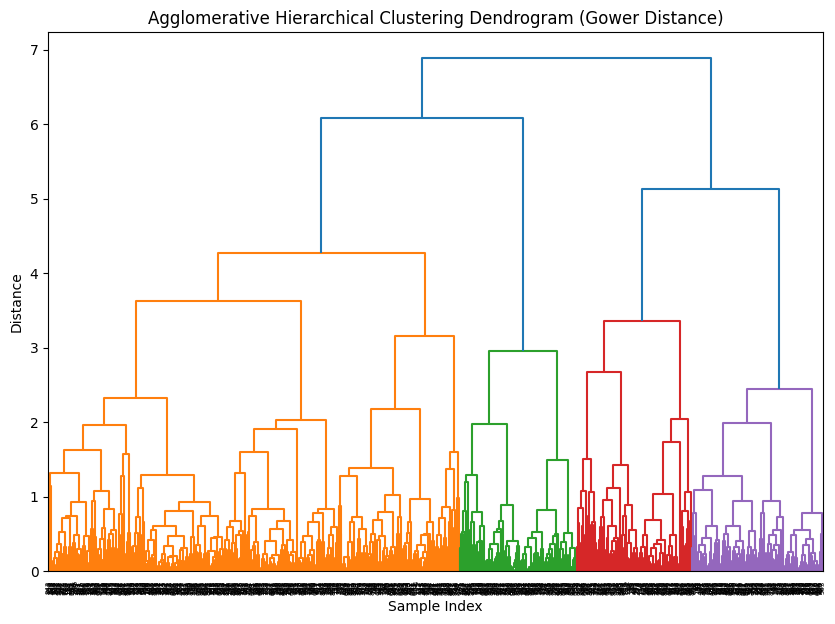

In [79]:
linked = linkage(gower_dist, 'average')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title('Agglomerative Hierarchical Clustering Dendrogram (Gower Distance)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

###### T-SNE

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


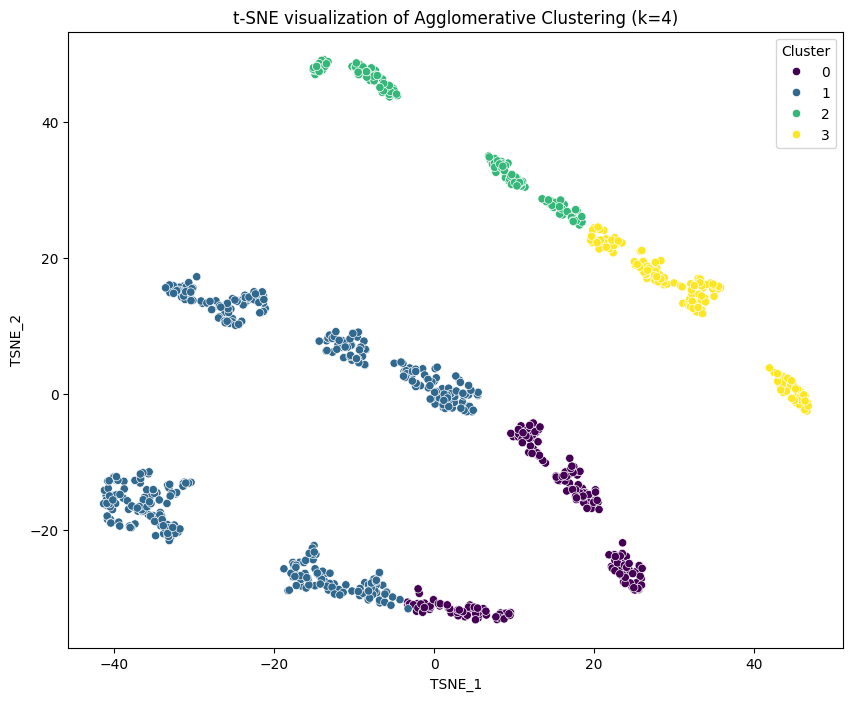

In [80]:
# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2,
            perplexity=30,
            learning_rate=200,
            n_iter=1000,
            random_state=42)

tsne_components = tsne.fit_transform(X_pca)

# DataFrame for the t-SNE
tsne_df = pd.DataFrame(data=tsne_components, columns=['TSNE_1', 'TSNE_2'])
tsne_df['Cluster'] = labels

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='Cluster', data=tsne_df, palette='viridis', legend='full')
plt.title('t-SNE visualization of Agglomerative Clustering (k=4)')
plt.xlabel('TSNE_1')
plt.ylabel('TSNE_2')
plt.show()

###### Cluster Analysis 2

Cluster Summary Table 2 (Mean of Numerical Features and Percentage of Categorical Features):


,age,mh_share,gender_Female,gender_Male,gender_Other,mental_health_Don't Know,mental_health_No,mental_health_Possibly,mental_health_Yes,benefits_I don't know,...,age_52.0,age_53.0,age_54.0,age_55.0,tech_company_0,tech_company_1,mental_health_binary_0,mental_health_binary_1,benefits_binary_0,benefits_binary_1
Agg_Cluster,,,,,,,,,,,,,,,,,,,,,
0,34.585366,8.170732,34.146341,60.975610,4.878049,0.975610,6.829268,13.658537,78.536585,22.926829,...,0.487805,0.487805,0.975610,0.000000,14.146341,85.853659,21.463415,78.536585,34.634146,65.365854
1,34.882075,5.648585,28.301887,68.160377,3.537736,8.726415,33.490566,25.707547,32.075472,45.283019,...,0.471698,1.415094,0.471698,1.179245,30.188679,69.811321,67.924528,32.075472,55.896226,44.103774
2,35.621429,6.250000,32.857143,65.714286,1.428571,7.857143,40.714286,23.571429,27.857143,0.000000,...,0.714286,1.428571,0.714286,0.714286,46.428571,53.571429,72.142857,27.857143,0.000000,100.000000
3,35.496815,8.108280,42.038217,50.318471,7.643312,1.273885,8.280255,11.464968,78.980892,0.000000,...,0.636943,0.000000,0.000000,0.000000,20.382166,79.617834,21.019108,78.980892,0.000000,100.000000


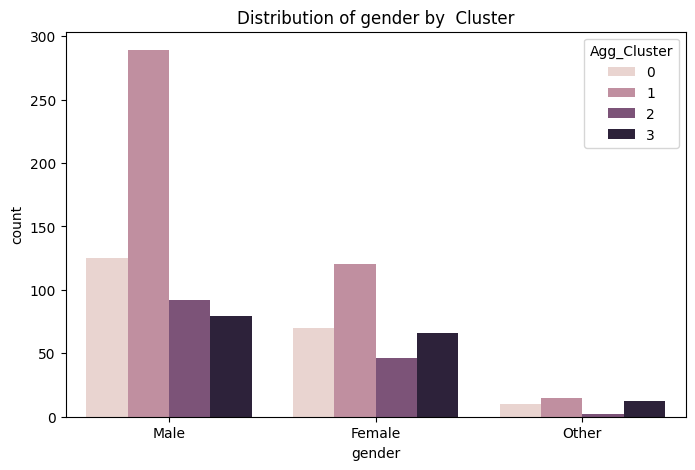

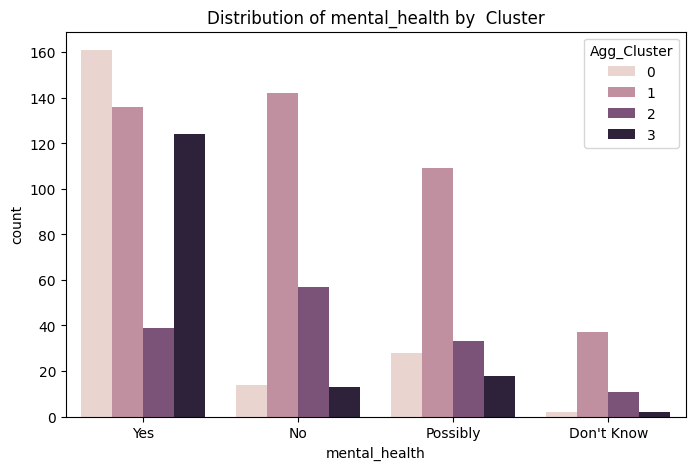

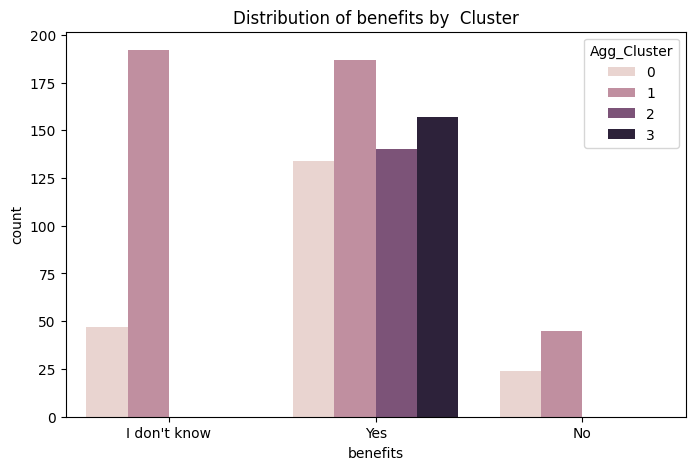

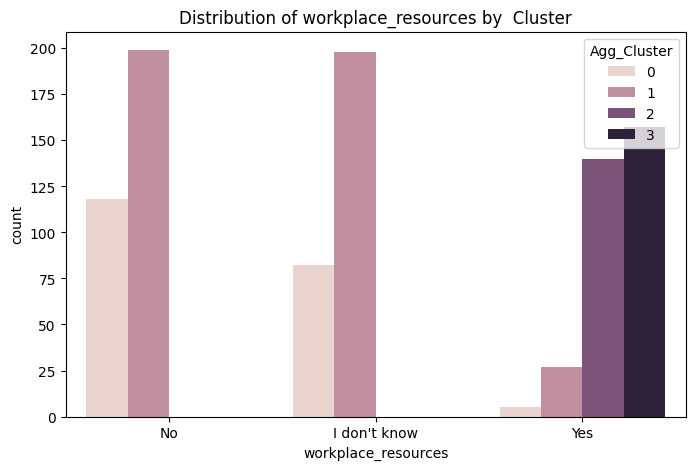

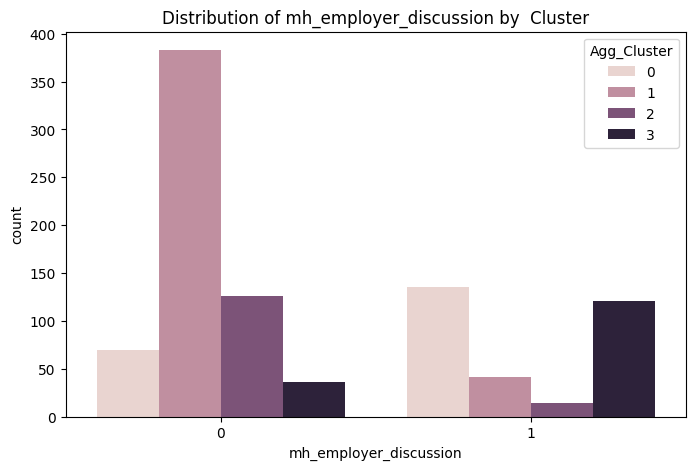

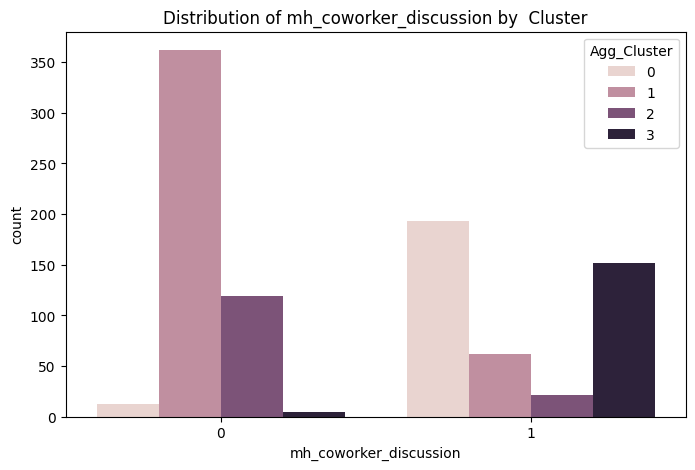

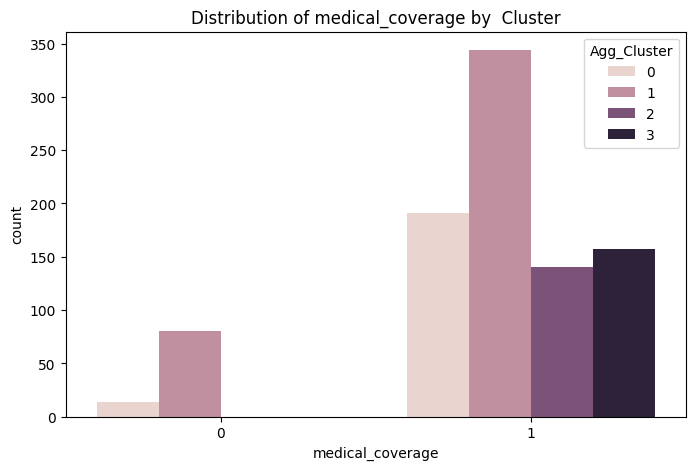

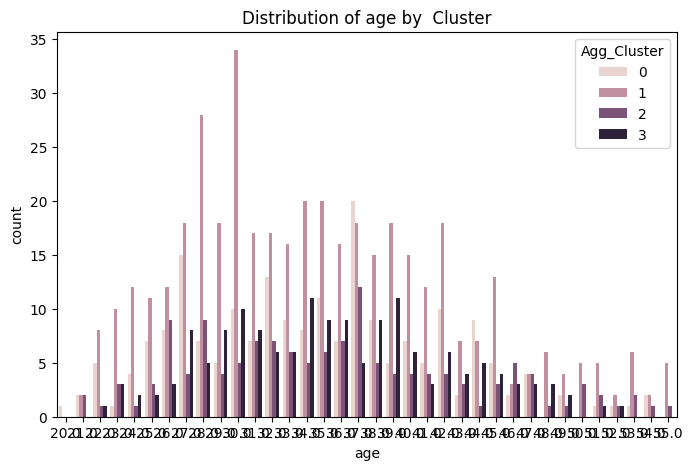

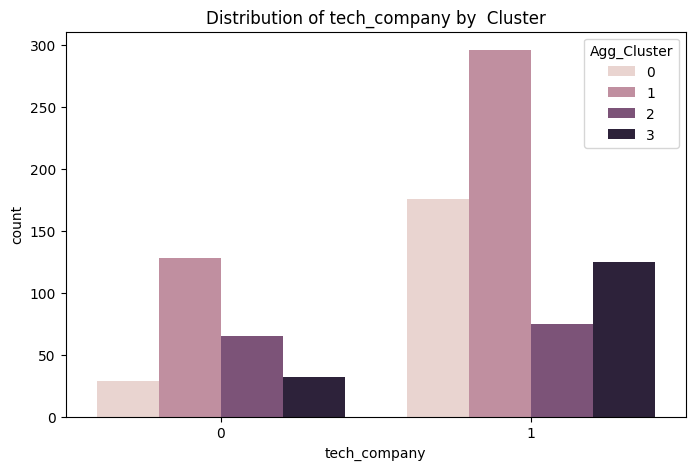

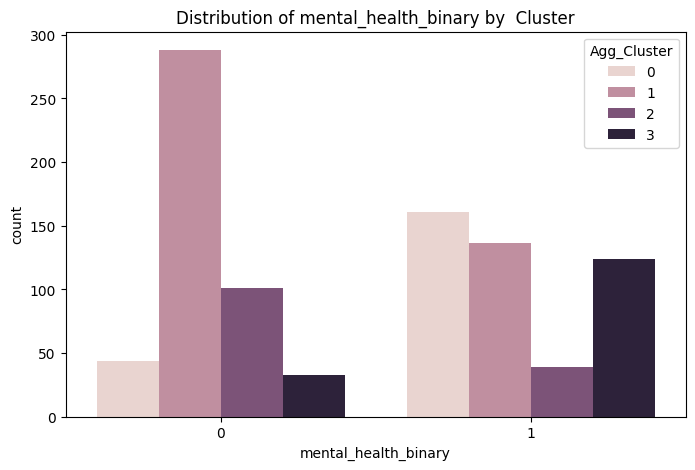

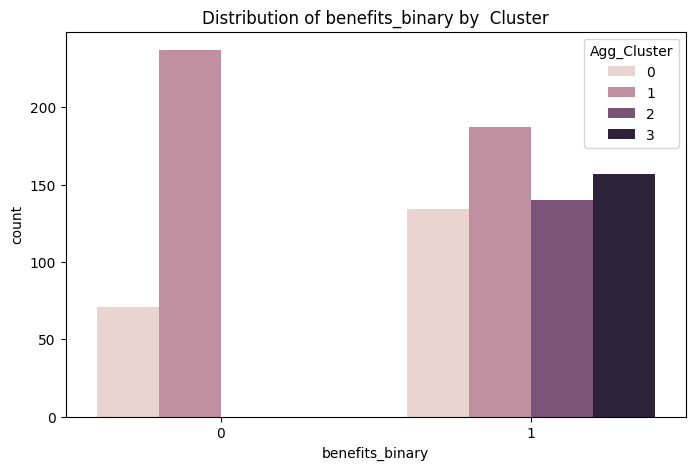

In [81]:
# @title
df_with_clusters2 = df.copy()
df_with_clusters2['Agg_Cluster'] = labels

# numerical features by cluster
numerical_features_to_analyze = ['age', 'mh_share']
cluster_numerical_means = df_with_clusters2.groupby('Agg_Cluster')[numerical_features_to_analyze].mean()

# categorical features by cluster
categorical_features_to_analyze = ['gender', 'mental_health', 'benefits', 'workplace_resources', 'mh_employer_discussion',
                                   'mh_coworker_discussion', 'medical_coverage','age','tech_company','mental_health_binary',
                                   'benefits_binary'] #,'country_group'

# distribution
cluster_categorical_distribution = {}
for col in categorical_features_to_analyze:
    # frequency and normalize
    distribution = df_with_clusters2.groupby('Agg_Cluster')[col].value_counts(normalize=True).mul(100).unstack(fill_value=0)
    cluster_categorical_distribution[col] = distribution

# numerical means
cluster_summary_table2 = cluster_numerical_means.copy()

# categorical distributions
for col, distribution_df in cluster_categorical_distribution.items():
    # Rename columns
    distribution_df.columns = [f'{col}_{cat}' for cat in distribution_df.columns]

    # summary table
    cluster_summary_table2 = cluster_summary_table2.join(distribution_df)


print("Cluster Summary Table 2 (Mean of Numerical Features and Percentage of Categorical Features):")
display(cluster_summary_table2)



for col in categorical_features_to_analyze:
  plt.figure(figsize=(8, 5))
  sns.countplot(data=df_with_clusters2, x=col, hue='Agg_Cluster')
  plt.title(f'Distribution of {col} by  Cluster')
  plt.show()

In [82]:
# Interpretable tables in the cluster table
# binary percentage is 100.0
columns_interpretation = ["age","gender_Male",'gender_Female','gender_Other',"mh_share",'mental_health_Yes',
                          'workplace_resources_Yes','benefits_Yes','tech_company_1', 'mh_coworker_discussion_1',
                          'mh_employer_discussion_1','mental_health_Possibly'] # ,'country_group_United States','country_group_Europe' exluded
cluster_summary_table2[columns_interpretation]

,age,gender_Male,gender_Female,gender_Other,mh_share,mental_health_Yes,workplace_resources_Yes,benefits_Yes,tech_company_1,mh_coworker_discussion_1,mh_employer_discussion_1,mental_health_Possibly
Agg_Cluster,,,,,,,,,,,,
0,34.585366,60.975610,34.146341,4.878049,8.170732,78.536585,2.439024,65.365854,85.853659,94.146341,65.853659,13.658537
1,34.882075,68.160377,28.301887,3.537736,5.648585,32.075472,6.367925,44.103774,69.811321,14.622642,9.669811,25.707547
2,35.621429,65.714286,32.857143,1.428571,6.250000,27.857143,100.000000,100.000000,53.571429,15.000000,10.000000,23.571429
3,35.496815,50.318471,42.038217,7.643312,8.108280,78.980892,100.000000,100.000000,79.617834,96.815287,77.070064,11.464968
